In [1]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer pandas plotly pyarrow

  Preparing metadata (setup.py) ... done
  Obtaining dependency information for wurlitzer from https://files.pythonhosted.org/packages/28/69/9d913bc2f85305c4eaf078fb22fd4828182b33189c1e78f2256ae27eaacb/wurlitzer-3.0.3-py3-none-any.whl.metadata
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=a64e676cf68103df5bd260c1933cb57c409a9e85893f2b4ed630a623b2f71b11
  Stored in directory: /root/.cache/pip/wheels/c8/c7/30/e5935be2cfa6883be72462333edc414d8928f3c78eaabec38a
Successfully built tdqm

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

2024-04-22 21:38:58.605415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 21:38:58.605468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 21:38:58.605490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 21:38:58.612715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    # root = os.path.join(".")
    root = os.path.join(".")
    DATA_LIMIT = 1000
    BATCH_SIZE = 32
    VIDEO_LENGTH = 25
    TRAIN_VAL_SPLIT = 0.8
    WANDB_RUN = "mediapipe-asl-dataset"


In [3]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])


EYE_LEFT = np.array([33, 7, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 471, 470, 469, 472])


EYE_RIGHT = np.array([362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 476, 475, 474, 477])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])


LIPS_END = len(LIPS_IDXS0)
EYE_LEFT_END = LIPS_END + len(EYE_LEFT)
EYE_RIGHT_END = EYE_LEFT_END + len(EYE_RIGHT)
LEFT_HAND_END = EYE_RIGHT_END + len(LEFT_HAND_IDXS0)
RIGHT_HAND_END = LEFT_HAND_END + len(RIGHT_HAND_IDXS0)
LEFT_POSE_END = RIGHT_HAND_END + len(LEFT_POSE_IDXS0)
RIGHT_POSE_END = LEFT_POSE_END + len(RIGHT_POSE_IDXS0)

print("LIPS : ",len(LIPS_IDXS0))
print("EYE_LEFT : ",len(EYE_LEFT))
print("EYE_RIGHT : ",len(EYE_RIGHT))
print("LEFT_HAND : ",len(LEFT_HAND_IDXS0))
print("RIGHT_HAND : ",len(RIGHT_HAND_IDXS0))
print("LEFT_POSE : ",len(LEFT_POSE_IDXS0))
print("RIGHT_POSE : ",len(RIGHT_POSE_IDXS0))

all_selection = np.concatenate([LIPS_IDXS0, EYE_LEFT, EYE_RIGHT, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0])
print(len(all_selection))

LIPS :  40
EYE_LEFT :  20
EYE_RIGHT :  20
LEFT_HAND :  21
RIGHT_HAND :  21
LEFT_POSE :  5
RIGHT_POSE :  5
132


In [4]:
def update_mean (values, mean, cnt):
    if np.any(np.isnan(values)):
        return mean, cnt
    
    mean += np.sum(values, axis=0)
    cnt += values.shape[0]
    return mean, cnt

def update_std(values, mean, std):
    if np.any(np.isnan(values)):
        return std
    
    std += np.sum((values - mean)**2, axis=0)
    return std

In [5]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import plotly.io as pio

def visualize_keypoints(frames : np.ndarray, point_size : int):
    if len(frames.shape) == 1:
        frames = np.array([frames])
    
    for frame in frames:
        frame = frame.reshape(-1, 3)
        sizes = point_size * np.ones(frame.shape[0])

        fig = go.Figure(data=go.Scatter(x=frame[:,0], y=2.5 - frame[:,1], mode='markers',
                                        marker=dict(
                                            size=sizes
                                            )))

    # Customize the layout
    fig.update_layout(title='visualization of human keypoints',
                        xaxis_title='',
                        yaxis_title='',
                        width=1000,
                        height=1600)

    fig.update_xaxes(range=[-0.2, 1.4])  # Set x-axis range from 0 to 6
    fig.update_yaxes(range=[0, 2.5])  # Set y-axis range from 10 to 20

    # Show the plot
    fig.show()

def process_parquet2(ds, idxes = None):
    ret = []    
    frame_size = 543
    it = len(ds) // frame_size
    assert it == len(ds) / frame_size
    
    for i in range(it):
        vals = ds.iloc[ i * frame_size : (i + 1 ) * frame_size ]        
        
        if idxes is not None:          
            vals = ds.iloc[idxes]
                        
        ret.append(np.array(vals[["x","y", "z"]]))
        
    return np.array(np.array(ret))

In [6]:
class Groups:
    def __init__(self):
        self.starts = []
        self.id_2_label = {}
        self.means = []
        self.cnts = []
        self.stds = []

    def add(self, start, name):
        self.id_2_label[len(self.starts)] = name
        self.starts.append(start)
        self.means.append(np.array([0.0,0.0,0.0]))
        self.cnts.append(0)
        self.stds.append(np.array([0.0,0.0,0.0]))
        
    def reset(self):
        for i in range(len(self.means)):
            self.means[i] = np.array([0,0,0])
            self.cnts[i] = 0
            self.stds[i] = np.array([0,0,0])
            
    def __str__(self):
        s = ""
        for i in range(len(self.starts)):
            s += f"name={self.id_2_label[i]} idxes = ({self.starts[i][0]}, {self.starts[i][1]}), mu={self.means[i]}, std = {self.stds[i]}\n"
        
        return s
    
#custom class to load data from Parquet files for training ML models.
class ParquetDatasetCached(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, groups : Groups=None, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 frame_length :int = CONFIG.VIDEO_LENGTH, split : str = "train", 
                 train_val_split : float = CONFIG.TRAIN_VAL_SPLIT, sort_by_counts : bool = True, 
                 idxes=None, **kwargs):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.cached_Y = None
        self.cached_X = None
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.group = groups
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        self.cache_data(idxes)
        self.calculate_props_for_groups()
                   
    def getGroups(self):
        return self.group
    
    def select(self, frames):
        current_length, num_features, _ = frames.shape
    
        if current_length >= CONFIG.VIDEO_LENGTH:
                # TODO: a better than uniform value ? Could place gaussian in the middle
                random_start = random.randint(0, current_length - CONFIG.VIDEO_LENGTH)
                return frames[random_start : (random_start + CONFIG.VIDEO_LENGTH)]
            
        # padd the video to contain zeros 
        return np.concatenate([frames, np.zeros((CONFIG.VIDEO_LENGTH - current_length, num_features,3))], axis=0)

    def preprocess(self, raw_frames):
        select_frames = self.select(raw_frames)
        t = select_frames.shape[0]
        
        for i in range(t):   
            for j in range(len(self.group.starts)):
                start = self.group.starts[j] 
                mean, std = self.group.means[j], self.group.stds[j]
                region = select_frames[i, start[0] : start[1], :]                
                region = (region - mean) / std
                region = np.nan_to_num(region)                
                select_frames[i, start[0] : start[1]] = region
                
                
        return select_frames.reshape(t, -1)
        
            
    def cache_data(self, idxes):
        self.cached_X, self.cached_Y = [], []
        
        pb = tqdm(range(len(self.dataset)), desc="Cacheing")

        for i in pb:
            
            path, label = self.dataset[i]
            df = pd.read_parquet(path)
                        
            one_hot_encoded_label = np.zeros(len(self.unique_labels))
            one_hot_encoded_label[self.label_2_id[label]] = 1

            self.cached_X.append(process_parquet2(df, idxes=idxes)) 
            self.cached_Y.append(one_hot_encoded_label)     
            
        
    def calculate_props_for_groups(self):
        
        if self.group is None:
            return 
                            
        for frames in tqdm(self.cached_X, desc="calculating means"):
            for frame in frames:
                for i in range(len(self.group.starts)):
                    start = self.group.starts[i]
                    mean = self.group.means[i]
                    cnts = self.group.cnts[i]
                    
                    feature = frame[start[0]:start[1]]
                    
                    self.group.means[i], self.group.cnts[i] = update_mean(feature, mean, cnts)                   
 
        
        # set the means 
        for i in range(len(self.group.starts)):            
            self.group.means[i] = self.group.means[i] / self.group.cnts[i]
            
        # calculate the standard deviations
        for frames in tqdm(self.cached_X, desc="calculating std"):
            for frame in frames:
                for i in range(len(self.group.starts)):
                    start = self.group.starts[i]
                    std = self.group.stds[i]
                    mean = self.group.means[i]                    
                    feature = frame[start[0]:start[1]]
                    
                    self.group.stds[i] = update_std(feature, mean=mean, std=std)                   
 
        # set the standard deviations 
        for i in range(len(self.group.starts)):            
            self.group.stds[i] = np.sqrt(self.group.stds[i] / self.group.cnts[i])
  
    def set_group(self, group):
        self.group = group

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.preprocess(self.cached_X[idx]), self.cached_Y[idx]                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)


    
groups = Groups()
groups.add((0, LIPS_END), "lips")
groups.add((LIPS_END, EYE_LEFT_END), "left eye")
groups.add((EYE_LEFT_END, EYE_RIGHT_END), "right eye")
groups.add((EYE_RIGHT_END, LEFT_HAND_END), "left hand")
groups.add((LEFT_HAND_END, RIGHT_HAND_END), "right hand")
groups.add((RIGHT_HAND_END, LEFT_POSE_END), "left pose")
groups.add((LEFT_POSE_END, RIGHT_POSE_END), "right pose")

# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT, groups=groups,
                                             check_if_file_exists = True,
                                             split="train", idxes= all_selection)

val_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 check_if_file_exists= True,
                                 split="val",idxes= all_selection)
val_dataset_parquet.set_group(train_dataset_parquet.group)

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

Cacheing: 100%|██████████| 200/200 [00:04<00:00, 48.56it/s]

cardinality of train : 800, cardinality of validation : 200


In [7]:
nans = False

for x, y in tqdm(train_dataset_parquet):
    nans |= np.any(np.isnan(x))
    if nans:
        print("SAD : ")
        break

for x, y in tqdm(val_dataset_parquet):
    nans |= np.any(np.isnan(x))
    if nans:    
        print("SAD : ")
        break


100%|██████████| 200/200 [00:00<00:00, 398.13it/s]


In [8]:
print(groups)

name=lips idxes = (0, 40), mu=[ 0.47021672  0.4764824  -0.02343413], std = [0.07918408 0.07547071 0.01623904]
name=left eye idxes = (40, 60), mu=[0.3986628  0.43055143 0.01069527], std = [0.14245859 0.14136499 0.03225427]
name=right eye idxes = (60, 80), mu=[ 0.51451116  0.40910735 -0.00128009], std = [0.10255321 0.12820712 0.04453863]
name=left hand idxes = (80, 101), mu=[ 0.6498931   0.62196375 -0.05204559], std = [0.15224076 0.16998623 0.06532311]
name=right hand idxes = (101, 122), mu=[ 0.30557308  0.58527081 -0.05768258], std = [0.1381897  0.15819383 0.05942085]
name=left pose idxes = (122, 127), mu=[ 0.87496043  0.95066813 -1.35376196], std = [0.17851542 0.27971058 0.70780739]
name=right pose idxes = (127, 132), mu=[ 0.11753856  0.93380588 -1.59372785], std = [0.1639152  0.31182161 0.97429655]



101 122 127
len(frames) = 3


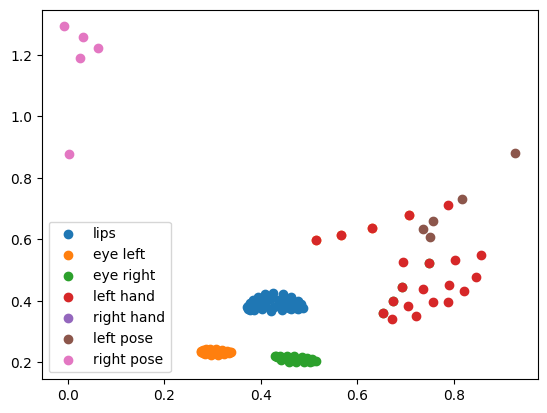

In [9]:
import matplotlib.pyplot as plt 

i = 1
LIPS_END = len(LIPS_IDXS0)
EYE_LEFT_END = LIPS_END + len(EYE_LEFT)
EYE_RIGHT_END = EYE_LEFT_END + len(EYE_RIGHT)
LEFT_HAND_END = EYE_RIGHT_END + len(LEFT_HAND_IDXS0)
RIGHT_HAND_END = LEFT_HAND_END + len(RIGHT_HAND_IDXS0)
LEFT_POSE_END = RIGHT_HAND_END + len(LEFT_POSE_IDXS0)
RIGHT_POSE_END = LEFT_POSE_END + len(RIGHT_POSE_IDXS0)

print(LEFT_HAND_END, RIGHT_HAND_END,LEFT_POSE_END)

frames = train_dataset_parquet.cached_X[i]
print(f"len(frames) = {len(frames)}")

frame = train_dataset_parquet.cached_X[0][0]

plt.scatter(frame[:LIPS_END, 0], frame[:LIPS_END, 1], label="lips")
plt.scatter(frame[LIPS_END:EYE_LEFT_END, 0], frame[LIPS_END:EYE_LEFT_END, 1], label="eye left")
plt.scatter(frame[EYE_LEFT_END:EYE_RIGHT_END,0], frame[EYE_LEFT_END:EYE_RIGHT_END, 1], label="eye right")
plt.scatter(frame[EYE_RIGHT_END:LEFT_HAND_END,0], frame[EYE_RIGHT_END:LEFT_HAND_END, 1], label="left hand")
plt.scatter(frame[LEFT_HAND_END:RIGHT_HAND_END, 0], frame[LEFT_HAND_END:RIGHT_HAND_END, 1], label="right hand")
plt.scatter(frame[RIGHT_HAND_END:LEFT_POSE_END, 0], frame[RIGHT_HAND_END:LEFT_POSE_END, 1], label="left pose")
plt.scatter(frame[LEFT_POSE_END:RIGHT_POSE_END, 0], frame[LEFT_POSE_END:RIGHT_POSE_END, 1], label="right pose")

plt.legend()
plt.show()

In [10]:
x, y = next(iter(train_dataset_parquet))
X_shape, Y_shape = x.shape, y.shape

In [11]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_dataset_parquet)):
        X_batch, Y_batch = train_dataset_parquet[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_dataset_parquet)):
        X_batch, Y_batch = val_dataset_parquet[i]
        yield X_batch, Y_batch        


train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

2024-04-22 21:39:31.407700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 180 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:04:00.0, compute capability: 8.6
2024-04-22 21:39:31.423633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 180.94MiB (189726720 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [12]:
for x,y in train_dataset:
    print(x)
    break

tf.Tensor(
[[[-1.23355842e+00 -1.24636483e+00  4.58735704e+00 ... -3.36595982e-01
    9.28819716e-01  6.78189099e-01]
  [-1.23355842e+00 -1.24636483e+00  4.58735704e+00 ... -3.36595982e-01
    9.28819716e-01  6.78189099e-01]
  [-1.23355842e+00 -1.24636483e+00  4.58735704e+00 ... -3.36595982e-01
    9.28819716e-01  6.78189099e-01]
  ...
  [-5.93827391e+00 -6.31347466e+00  1.44307327e+00 ... -7.17069268e-01
   -2.99467969e+00  1.63577282e+00]
  [-5.93827391e+00 -6.31347466e+00  1.44307327e+00 ... -7.17069268e-01
   -2.99467969e+00  1.63577282e+00]
  [-5.93827391e+00 -6.31347466e+00  1.44307327e+00 ... -7.17069268e-01
   -2.99467969e+00  1.63577282e+00]]

 [[-3.15966034e+00 -1.26942301e+00  9.81657624e-01 ... -7.41855353e-02
    4.83052999e-01  5.50546765e-01]
  [-3.15966034e+00 -1.26942301e+00  9.81657624e-01 ... -7.41855353e-02
    4.83052999e-01  5.50546765e-01]
  [-3.15966034e+00 -1.26942301e+00  9.81657624e-01 ... -7.41855353e-02
    4.83052999e-01  5.50546765e-01]
  ...
  [-5.938273

1it [00:00,  8.39it/s]

(32, 25, 396) (32, 3)


25it [00:02,  9.81it/s]


Iterating through dataset took : 2.5526s


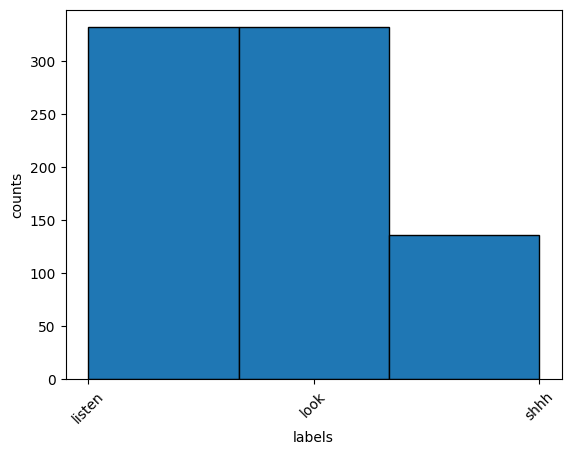

In [13]:
start = time.time()
isnans =False

id2label = {v : k for k,v in train_dataset_parquet.label_2_id.items()}

f = True
labels_batches = []
for el in tqdm(train_dataset):
    if f:
        print(el[0].shape, el[1].shape)
        f = False

    ls = np.argmax(el[1], axis=1)
    for l in ls:
        labels_batches.append(id2label[l])
    
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break

print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")
plt.hist(labels_batches, bins=len(np.unique(labels_batches)), edgecolor="black")
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('')

# Rotate x-axis ticks
plt.xticks(rotation=45)
plt.savefig("histogram.png")
plt.show()

# Train experiment

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=51, epochs=100, run_name="",
                mediapipe_features = "all", USE_WANDB=True): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, weight_decay=1e-5, clipnorm=1.)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.2)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['categorical_accuracy'])
    
    
    callbacks  = [checkpoint, cosine_annealer]
    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : 5e-5, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : len(train_dataset_parquet.dataset),
                                "val_size" : len(val_dataset_parquet.dataset),
                                "unique_classes" : len(train_dataset_parquet.unique_labels), 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "features" : mediapipe_features
                                })
        callbacks.append(WandbMetricsLogger())


    history = model.fit(train_dataset, epochs=epochs, validation_data = val_dataset, callbacks=callbacks)
    
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Train simple LSTM

In [15]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(X_shape[0], X_shape[1]),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM164-LR-D256-GELU-reduced-reduced-1k.tf"),
            run_name="LSTM164-LR-D256-GELU-reduced-reduced-1k",
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

2024-04-22 21:39:34.395343: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


Epoch 1/100


2024-04-22 21:39:39.881199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:447] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2024-04-22 21:39:39.881272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:451] Memory usage: 7274496 bytes free, 25438126080 bytes total.
2024-04-22 21:39:39.881310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:461] Possibly insufficient driver version: 525.105.17
2024-04-22 21:39:39.881326: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at cudnn_rnn_ops.cc:1764 : UNKNOWN: Fail to find the dnn implementation.


UnknownError: Graph execution error:

Detected at node CudnnRNN defined at (most recent call last):
<stack traces unavailable>
Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_3983]

In [60]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=(X_shape[0], X_shape[1]),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM1-2.tf"),
            run_name="LSTM128-Dense128-Dense256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            USE_WANDB=False)

Epoch 1/100
     50/Unknown - 9s 132ms/step - loss: nan - categorical_accuracy: 0.0950

KeyboardInterrupt: 

In [123]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(X_shape[0], X_shape[1]),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM1-3.tf"),
            run_name="LSTM64-Dense128-Dense256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            USE_WANDB=True)

Epoch 1/100
    494/Unknown - 6s 6ms/step - loss: 2.5751 - categorical_accuracy: 0.1043

2024-04-16 14:21:49.586712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7580302709240232395
2024-04-16 14:21:49.586753: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1486800163596208403
2024-04-16 14:21:49.586767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1011830033887524483
2024-04-16 14:21:49.586779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4153888742695321310
2024-04-16 14:21:50.744220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3771462535022358857
2024-04-16 14:21:50.744267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3371227081520258209
2024-04-16 14:21:50.744283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 14s 22ms/step - loss: 2.5744 - categorical_accuracy: 0.1063 - val_loss: 2.5371 - val_categorical_accuracy: 0.1400
Epoch 2/100
498/500 [============================>.] - ETA: 0s - loss: 2.4465 - categorical_accuracy: 0.1574INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 2.4459 - categorical_accuracy: 0.1567 - val_loss: 2.3761 - val_categorical_accuracy: 0.1940
Epoch 3/100
493/500 [============================>.] - ETA: 0s - loss: 2.3787 - categorical_accuracy: 0.1833INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.3786 - categorical_accuracy: 0.1835 - val_loss: 2.3476 - val_categorical_accuracy: 0.2160
Epoch 4/100
496/500 [============================>.] - ETA: 0s - loss: 2.3495 - categorical_accuracy: 0.2036INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.3490 - categorical_accuracy: 0.2030 - val_loss: 2.3199 - val_categorical_accuracy: 0.2310
Epoch 5/100
494/500 [============================>.] - ETA: 0s - loss: 2.3254 - categorical_accuracy: 0.2234INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.3252 - categorical_accuracy: 0.2230 - val_loss: 2.2948 - val_categorical_accuracy: 0.2550
Epoch 6/100
498/500 [============================>.] - ETA: 0s - loss: 2.3054 - categorical_accuracy: 0.2415INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.3053 - categorical_accuracy: 0.2412 - val_loss: 2.2704 - val_categorical_accuracy: 0.2700
Epoch 7/100
500/500 [==============================] - 4s 7ms/step - loss: 2.2840 - categorical_accuracy: 0.2447 - val_loss: 2.2611 - val_categorical_accuracy: 0.2690
Epoch 8/100
494/500 [============================>.] - ETA: 0s - loss: 2.2694 - categorical_accuracy: 0.2424INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.2693 - categorical_accuracy: 0.2428 - val_loss: 2.2539 - val_categorical_accuracy: 0.2750
Epoch 9/100
494/500 [============================>.] - ETA: 0s - loss: 2.2539 - categorical_accuracy: 0.2551INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 23ms/step - loss: 2.2537 - categorical_accuracy: 0.2548 - val_loss: 2.2384 - val_categorical_accuracy: 0.2790
Epoch 10/100
491/500 [============================>.] - ETA: 0s - loss: 2.2448 - categorical_accuracy: 0.2747INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.2444 - categorical_accuracy: 0.2755 - val_loss: 2.2252 - val_categorical_accuracy: 0.2910
Epoch 11/100
500/500 [==============================] - ETA: 0s - loss: 2.2272 - categorical_accuracy: 0.2775INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.2272 - categorical_accuracy: 0.2775 - val_loss: 2.2113 - val_categorical_accuracy: 0.3020
Epoch 12/100
492/500 [============================>.] - ETA: 0s - loss: 2.2144 - categorical_accuracy: 0.2950INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.2131 - categorical_accuracy: 0.2962 - val_loss: 2.1871 - val_categorical_accuracy: 0.3120
Epoch 13/100
499/500 [============================>.] - ETA: 0s - loss: 2.1986 - categorical_accuracy: 0.3056INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.1982 - categorical_accuracy: 0.3060 - val_loss: 2.1749 - val_categorical_accuracy: 0.3290
Epoch 14/100
500/500 [==============================] - 4s 7ms/step - loss: 2.1849 - categorical_accuracy: 0.3122 - val_loss: 2.1619 - val_categorical_accuracy: 0.3180
Epoch 15/100
492/500 [============================>.] - ETA: 0s - loss: 2.1735 - categorical_accuracy: 0.3211INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.1721 - categorical_accuracy: 0.3220 - val_loss: 2.1553 - val_categorical_accuracy: 0.3330
Epoch 16/100
500/500 [==============================] - 3s 7ms/step - loss: 2.1567 - categorical_accuracy: 0.3368 - val_loss: 2.1553 - val_categorical_accuracy: 0.3200
Epoch 17/100
497/500 [============================>.] - ETA: 0s - loss: 2.1440 - categorical_accuracy: 0.3400INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.1425 - categorical_accuracy: 0.3408 - val_loss: 2.1429 - val_categorical_accuracy: 0.3410
Epoch 18/100
500/500 [==============================] - 3s 7ms/step - loss: 2.1320 - categorical_accuracy: 0.3483 - val_loss: 2.1302 - val_categorical_accuracy: 0.3340
Epoch 19/100
497/500 [============================>.] - ETA: 0s - loss: 2.1225 - categorical_accuracy: 0.3521INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.1211 - categorical_accuracy: 0.3530 - val_loss: 2.1167 - val_categorical_accuracy: 0.3450
Epoch 20/100
498/500 [============================>.] - ETA: 0s - loss: 2.1092 - categorical_accuracy: 0.3577INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 2.1085 - categorical_accuracy: 0.3580 - val_loss: 2.1173 - val_categorical_accuracy: 0.3520
Epoch 21/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0984 - categorical_accuracy: 0.3655 - val_loss: 2.1079 - val_categorical_accuracy: 0.3430
Epoch 22/100
500/500 [==============================] - 4s 7ms/step - loss: 2.0867 - categorical_accuracy: 0.3758 - val_loss: 2.1076 - val_categorical_accuracy: 0.3480
Epoch 23/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0776 - categorical_accuracy: 0.3823 - val_loss: 2.1120 - val_categorical_accuracy: 0.3500
Epoch 24/100
494/500 [============================>.] - ETA: 0s - loss: 2.0670 - categorical_accuracy: 0.3813INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.0656 - categorical_accuracy: 0.3825 - val_loss: 2.0905 - val_categorical_accuracy: 0.3650
Epoch 25/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0545 - categorical_accuracy: 0.3955 - val_loss: 2.0955 - val_categorical_accuracy: 0.3460
Epoch 26/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0429 - categorical_accuracy: 0.4060 - val_loss: 2.0900 - val_categorical_accuracy: 0.3590
Epoch 27/100
494/500 [============================>.] - ETA: 0s - loss: 2.0377 - categorical_accuracy: 0.4016INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 2.0369 - categorical_accuracy: 0.4022 - val_loss: 2.0765 - val_categorical_accuracy: 0.3730
Epoch 28/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0270 - categorical_accuracy: 0.4160 - val_loss: 2.0819 - val_categorical_accuracy: 0.3620
Epoch 29/100
498/500 [============================>.] - ETA: 0s - loss: 2.0123 - categorical_accuracy: 0.4275INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.0115 - categorical_accuracy: 0.4280 - val_loss: 2.0657 - val_categorical_accuracy: 0.3960
Epoch 30/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0050 - categorical_accuracy: 0.4297 - val_loss: 2.0684 - val_categorical_accuracy: 0.3890
Epoch 31/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9892 - categorical_accuracy: 0.4445 - val_loss: 2.0638 - val_categorical_accuracy: 0.3910
Epoch 32/100
500/500 [==============================] - 4s 7ms/step - loss: 1.9824 - categorical_accuracy: 0.4502 - val_loss: 2.0563 - val_categorical_accuracy: 0.3950
Epoch 33/100
492/500 [============================>.] - ETA: 0s - loss: 1.9735 - categorical_accuracy: 0.4484INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.9726 - categorical_accuracy: 0.4485 - val_loss: 2.0426 - val_categorical_accuracy: 0.3990
Epoch 34/100
495/500 [============================>.] - ETA: 0s - loss: 1.9642 - categorical_accuracy: 0.4624INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.9631 - categorical_accuracy: 0.4625 - val_loss: 2.0376 - val_categorical_accuracy: 0.4090
Epoch 35/100
500/500 [==============================] - 4s 7ms/step - loss: 1.9554 - categorical_accuracy: 0.4640 - val_loss: 2.0410 - val_categorical_accuracy: 0.3990
Epoch 36/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9462 - categorical_accuracy: 0.4737 - val_loss: 2.0567 - val_categorical_accuracy: 0.3940
Epoch 37/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9403 - categorical_accuracy: 0.4748 - val_loss: 2.0506 - val_categorical_accuracy: 0.3920
Epoch 38/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9330 - categorical_accuracy: 0.4782 - val_loss: 2.0266 - val_categorical_accuracy: 0.4050
Epoch 39/100
500/500 [==============================] - 4s 7ms/step - loss: 1.9225 - categorical_accuracy: 0.4870 - val_loss: 2.0357 - val_categorical_accuracy: 0.3970
Epo

INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.9159 - categorical_accuracy: 0.4863 - val_loss: 2.0321 - val_categorical_accuracy: 0.4130
Epoch 41/100
500/500 [==============================] - 4s 7ms/step - loss: 1.9114 - categorical_accuracy: 0.4877 - val_loss: 2.0368 - val_categorical_accuracy: 0.4110
Epoch 42/100
500/500 [==============================] - 4s 7ms/step - loss: 1.9067 - categorical_accuracy: 0.4988 - val_loss: 2.0395 - val_categorical_accuracy: 0.4040
Epoch 43/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8968 - categorical_accuracy: 0.5005 - val_loss: 2.0267 - val_categorical_accuracy: 0.4100
Epoch 44/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8952 - categorical_accuracy: 0.4978 - val_loss: 2.0218 - val_categorical_accuracy: 0.4130
Epoch 45/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8929 - categorical_accuracy: 0.5015 - val_loss: 2.0344 - val_categorical_accuracy: 0.4060
Epo

INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.8837 - categorical_accuracy: 0.5005 - val_loss: 2.0073 - val_categorical_accuracy: 0.4280
Epoch 48/100
496/500 [============================>.] - ETA: 0s - loss: 1.8736 - categorical_accuracy: 0.5154INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8725 - categorical_accuracy: 0.5155 - val_loss: 2.0097 - val_categorical_accuracy: 0.4340
Epoch 49/100
500/500 [==============================] - 4s 7ms/step - loss: 1.8667 - categorical_accuracy: 0.5135 - val_loss: 2.0133 - val_categorical_accuracy: 0.4250
Epoch 50/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9156 - categorical_accuracy: 0.4857 - val_loss: 2.0037 - val_categorical_accuracy: 0.4340
Epoch 51/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9073 - categorical_accuracy: 0.4910 - val_loss: 2.0392 - val_categorical_accuracy: 0.3960
Epoch 52/100
500/500 [==============================] - 4s 7ms/step - loss: 1.9080 - categorical_accuracy: 0.4970 - val_loss: 2.0256 - val_categorical_accuracy: 0.4180
Epoch 53/100
494/500 [============================>.] - ETA: 0s - loss: 1.9019 - categorical_accuracy: 0.4909INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.9018 - categorical_accuracy: 0.4913 - val_loss: 1.9863 - val_categorical_accuracy: 0.4440
Epoch 54/100
500/500 [==============================] - 4s 7ms/step - loss: 1.8826 - categorical_accuracy: 0.5033 - val_loss: 2.0288 - val_categorical_accuracy: 0.4320
Epoch 55/100
498/500 [============================>.] - ETA: 0s - loss: 1.8826 - categorical_accuracy: 0.5028INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8816 - categorical_accuracy: 0.5040 - val_loss: 1.9954 - val_categorical_accuracy: 0.4530
Epoch 56/100
500/500 [==============================] - 4s 7ms/step - loss: 1.8721 - categorical_accuracy: 0.5080 - val_loss: 2.0111 - val_categorical_accuracy: 0.4470
Epoch 57/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8705 - categorical_accuracy: 0.5182 - val_loss: 1.9979 - val_categorical_accuracy: 0.4500
Epoch 58/100
500/500 [==============================] - 4s 7ms/step - loss: 1.8750 - categorical_accuracy: 0.5080 - val_loss: 1.9921 - val_categorical_accuracy: 0.4470
Epoch 59/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8504 - categorical_accuracy: 0.5255 - val_loss: 1.9855 - val_categorical_accuracy: 0.4470
Epoch 60/100
496/500 [============================>.] - ETA: 0s - loss: 1.8474 - categorical_accuracy: 0.5292INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8461 - categorical_accuracy: 0.5300 - val_loss: 1.9910 - val_categorical_accuracy: 0.4550
Epoch 61/100
492/500 [============================>.] - ETA: 0s - loss: 1.8574 - categorical_accuracy: 0.5272INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.8573 - categorical_accuracy: 0.5270 - val_loss: 2.0022 - val_categorical_accuracy: 0.4610
Epoch 62/100
497/500 [============================>.] - ETA: 0s - loss: 1.8352 - categorical_accuracy: 0.5337INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.8335 - categorical_accuracy: 0.5345 - val_loss: 1.9828 - val_categorical_accuracy: 0.4670
Epoch 63/100
500/500 [==============================] - 4s 7ms/step - loss: 1.8352 - categorical_accuracy: 0.5385 - val_loss: 1.9890 - val_categorical_accuracy: 0.4660
Epoch 64/100
492/500 [============================>.] - ETA: 0s - loss: 1.8333 - categorical_accuracy: 0.5368INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8336 - categorical_accuracy: 0.5365 - val_loss: 1.9834 - val_categorical_accuracy: 0.4770
Epoch 65/100
499/500 [============================>.] - ETA: 0s - loss: 1.8170 - categorical_accuracy: 0.5433INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8162 - categorical_accuracy: 0.5440 - val_loss: 1.9597 - val_categorical_accuracy: 0.4840
Epoch 66/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8123 - categorical_accuracy: 0.5487 - val_loss: 2.0008 - val_categorical_accuracy: 0.4700
Epoch 67/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8097 - categorical_accuracy: 0.5477 - val_loss: 2.0154 - val_categorical_accuracy: 0.4480
Epoch 68/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7971 - categorical_accuracy: 0.5515 - val_loss: 1.9714 - val_categorical_accuracy: 0.4740
Epoch 69/100
500/500 [==============================] - 4s 7ms/step - loss: 1.7853 - categorical_accuracy: 0.5660 - val_loss: 1.9674 - val_categorical_accuracy: 0.4730
Epoch 70/100
500/500 [==============================] - 4s 7ms/step - loss: 1.7875 - categorical_accuracy: 0.5620 - val_loss: 2.0018 - val_categorical_accuracy: 0.4650
Epo

INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.7738 - categorical_accuracy: 0.5745 - val_loss: 1.9736 - val_categorical_accuracy: 0.4860
Epoch 73/100
491/500 [============================>.] - ETA: 0s - loss: 1.7643 - categorical_accuracy: 0.5782INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7642 - categorical_accuracy: 0.5775 - val_loss: 1.9471 - val_categorical_accuracy: 0.4960
Epoch 74/100
500/500 [==============================] - 4s 7ms/step - loss: 1.7610 - categorical_accuracy: 0.5828 - val_loss: 1.9566 - val_categorical_accuracy: 0.4900
Epoch 75/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7545 - categorical_accuracy: 0.5850 - val_loss: 1.9730 - val_categorical_accuracy: 0.4930
Epoch 76/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7455 - categorical_accuracy: 0.5895 - val_loss: 1.9685 - val_categorical_accuracy: 0.4940
Epoch 77/100
500/500 [==============================] - ETA: 0s - loss: 1.7349 - categorical_accuracy: 0.5938INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7349 - categorical_accuracy: 0.5938 - val_loss: 1.9566 - val_categorical_accuracy: 0.4980
Epoch 78/100
500/500 [==============================] - 4s 7ms/step - loss: 1.7346 - categorical_accuracy: 0.6010 - val_loss: 1.9772 - val_categorical_accuracy: 0.4900
Epoch 79/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7297 - categorical_accuracy: 0.6012 - val_loss: 2.0076 - val_categorical_accuracy: 0.4850
Epoch 80/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7294 - categorical_accuracy: 0.6035 - val_loss: 1.9587 - val_categorical_accuracy: 0.4950
Epoch 81/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7206 - categorical_accuracy: 0.6003 - val_loss: 1.9667 - val_categorical_accuracy: 0.4930
Epoch 82/100
500/500 [==============================] - ETA: 0s - loss: 1.7164 - categorical_accuracy: 0.6093INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7164 - categorical_accuracy: 0.6093 - val_loss: 1.9402 - val_categorical_accuracy: 0.5050
Epoch 83/100
500/500 [==============================] - 4s 7ms/step - loss: 1.7155 - categorical_accuracy: 0.6120 - val_loss: 1.9724 - val_categorical_accuracy: 0.4890
Epoch 84/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7063 - categorical_accuracy: 0.6160 - val_loss: 1.9633 - val_categorical_accuracy: 0.4930
Epoch 85/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7045 - categorical_accuracy: 0.6080 - val_loss: 1.9726 - val_categorical_accuracy: 0.4890
Epoch 86/100
500/500 [==============================] - 4s 7ms/step - loss: 1.6985 - categorical_accuracy: 0.6175 - val_loss: 1.9674 - val_categorical_accuracy: 0.4920
Epoch 87/100
500/500 [==============================] - 4s 7ms/step - loss: 1.6974 - categorical_accuracy: 0.6173 - val_loss: 1.9541 - val_categorical_accuracy: 0.5030
Epo

INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.6748 - categorical_accuracy: 0.6230 - val_loss: 1.9523 - val_categorical_accuracy: 0.5070
Epoch 94/100
500/500 [==============================] - 4s 7ms/step - loss: 1.6754 - categorical_accuracy: 0.6200 - val_loss: 1.9660 - val_categorical_accuracy: 0.5010
Epoch 95/100
500/500 [==============================] - 3s 7ms/step - loss: 1.6653 - categorical_accuracy: 0.6280 - val_loss: 1.9647 - val_categorical_accuracy: 0.5040
Epoch 96/100
499/500 [============================>.] - ETA: 0s - loss: 1.6635 - categorical_accuracy: 0.6335INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1-3.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.6625 - categorical_accuracy: 0.6340 - val_loss: 1.9257 - val_categorical_accuracy: 0.5210
Epoch 97/100
500/500 [==============================] - 4s 7ms/step - loss: 1.6668 - categorical_accuracy: 0.6308 - val_loss: 1.9498 - val_categorical_accuracy: 0.5150
Epoch 98/100
500/500 [==============================] - 3s 7ms/step - loss: 1.6534 - categorical_accuracy: 0.6415 - val_loss: 1.9518 - val_categorical_accuracy: 0.5090
Epoch 99/100
500/500 [==============================] - 3s 7ms/step - loss: 1.6566 - categorical_accuracy: 0.6370 - val_loss: 1.9675 - val_categorical_accuracy: 0.4930
Epoch 100/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7232 - categorical_accuracy: 0.6025 - val_loss: 1.9353 - val_categorical_accuracy: 0.4980


epoch/categorical_accuracy,▁▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▄▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██▇████▇███
epoch/val_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁
epoch/categorical_accuracy,0.6025
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,1.72324
epoch/val_categorical_accuracy,0.498


In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM256-Dense128-Dense256-LipsEyesHandsPose_5k.tf"),
            run_name="LSTM256-Dense128-Dense256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            USE_WANDB=True)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128-Dense256-allfeatures.tf"),
            run_name="LSTM128-Dense256-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128-Dense128-allfeatures.tf"),
            run_name="LSTM128-Dense128-allfeatures")

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0000001), 
               activity_regularizer=l2(0.0000001)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128_l2-Dense128-Dense256-allfeatures.tf"),
            run_name="LSTM128_l2-Dense128-Dense256-allfeatures")

In [46]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.005), 
               activity_regularizer=l2(0.005)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM-L64-D128-D256-reg=0.005.tf"),
            run_name="LSTM64-Dense128-Dense256-allfeatures_bigger_reg")

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.36889
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,2.82214
epoch/val_categorical_accuracy,0.45


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 2.8411 - categorical_accuracy: 0.4000INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 60s 499ms/step - loss: 2.8411 - categorical_accuracy: 0.4000 - val_loss: 2.4088 - val_categorical_accuracy: 0.4200
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 2.1274 - categorical_accuracy: 0.4056INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 502ms/step - loss: 2.1274 - categorical_accuracy: 0.4056 - val_loss: 1.8624 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 49s 439ms/step - loss: 1.7043 - categorical_accuracy: 0.4044 - val_loss: 1.5451 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - 50s 445ms/step - loss: 1.4585 - categorical_accuracy: 0.4056 - val_loss: 1.3563 - val_categorical_accuracy: 0.4400
Epoch 5/100
113/113 [==============================] - 50s 441ms/step - loss: 1.3106 - categorical_accuracy: 0.4056 - val_loss: 1.2412 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 1.2187 - categorical_accuracy: 0.4167INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 1.2187 - categorical_accuracy: 0.4167 - val_loss: 1.1653 - val_categorical_accuracy: 0.4200
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 1.1668 - categorical_accuracy: 0.4211INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 1.1668 - categorical_accuracy: 0.4211 - val_loss: 1.0656 - val_categorical_accuracy: 0.5000
Epoch 8/100
113/113 [==============================] - 50s 442ms/step - loss: 1.1402 - categorical_accuracy: 0.4167 - val_loss: 1.0608 - val_categorical_accuracy: 0.5100
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 1.0638 - categorical_accuracy: 0.4833INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 1.0638 - categorical_accuracy: 0.4833 - val_loss: 0.9921 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 1.0240 - categorical_accuracy: 0.4889INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 500ms/step - loss: 1.0240 - categorical_accuracy: 0.4889 - val_loss: 1.0163 - val_categorical_accuracy: 0.5200
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 1.0002 - categorical_accuracy: 0.5100INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 1.0002 - categorical_accuracy: 0.5100 - val_loss: 0.9776 - val_categorical_accuracy: 0.5200
Epoch 12/100
113/113 [==============================] - ETA: 0s - loss: 0.9623 - categorical_accuracy: 0.5144INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.9623 - categorical_accuracy: 0.5144 - val_loss: 0.9214 - val_categorical_accuracy: 0.5500
Epoch 13/100
113/113 [==============================] - ETA: 0s - loss: 0.9209 - categorical_accuracy: 0.5544INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.9209 - categorical_accuracy: 0.5544 - val_loss: 0.8942 - val_categorical_accuracy: 0.5600
Epoch 14/100
113/113 [==============================] - 50s 446ms/step - loss: 0.9315 - categorical_accuracy: 0.5333 - val_loss: 0.9100 - val_categorical_accuracy: 0.5400
Epoch 15/100
113/113 [==============================] - ETA: 0s - loss: 0.8799 - categorical_accuracy: 0.5733INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.8799 - categorical_accuracy: 0.5733 - val_loss: 0.8732 - val_categorical_accuracy: 0.5500
Epoch 16/100
113/113 [==============================] - 50s 443ms/step - loss: 0.8731 - categorical_accuracy: 0.5589 - val_loss: 0.8565 - val_categorical_accuracy: 0.5900
Epoch 17/100
113/113 [==============================] - 50s 447ms/step - loss: 0.8757 - categorical_accuracy: 0.5556 - val_loss: 0.8595 - val_categorical_accuracy: 0.5800
Epoch 18/100
113/113 [==============================] - 50s 444ms/step - loss: 0.8616 - categorical_accuracy: 0.5733 - val_loss: 0.8362 - val_categorical_accuracy: 0.6100
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.8751 - categorical_accuracy: 0.5800INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.8751 - categorical_accuracy: 0.5800 - val_loss: 0.8408 - val_categorical_accuracy: 0.5700
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.8239 - categorical_accuracy: 0.6022INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 502ms/step - loss: 0.8239 - categorical_accuracy: 0.6022 - val_loss: 0.8111 - val_categorical_accuracy: 0.6000
Epoch 21/100
113/113 [==============================] - ETA: 0s - loss: 0.8207 - categorical_accuracy: 0.6067INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 511ms/step - loss: 0.8207 - categorical_accuracy: 0.6067 - val_loss: 0.8012 - val_categorical_accuracy: 0.6100
Epoch 22/100
113/113 [==============================] - ETA: 0s - loss: 0.7945 - categorical_accuracy: 0.6511INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.7945 - categorical_accuracy: 0.6511 - val_loss: 0.7536 - val_categorical_accuracy: 0.6500
Epoch 23/100
113/113 [==============================] - 50s 443ms/step - loss: 0.7951 - categorical_accuracy: 0.6400 - val_loss: 0.9351 - val_categorical_accuracy: 0.6400
Epoch 24/100
113/113 [==============================] - 50s 449ms/step - loss: 0.8354 - categorical_accuracy: 0.6267 - val_loss: 1.3834 - val_categorical_accuracy: 0.3300
Epoch 25/100
113/113 [==============================] - ETA: 0s - loss: 0.7755 - categorical_accuracy: 0.6633INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 499ms/step - loss: 0.7755 - categorical_accuracy: 0.6633 - val_loss: 0.7559 - val_categorical_accuracy: 0.6800
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.7431 - categorical_accuracy: 0.7156INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.7431 - categorical_accuracy: 0.7156 - val_loss: 0.8453 - val_categorical_accuracy: 0.5700
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.7037 - categorical_accuracy: 0.7278INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 502ms/step - loss: 0.7037 - categorical_accuracy: 0.7278 - val_loss: 0.7106 - val_categorical_accuracy: 0.7100
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.6386 - categorical_accuracy: 0.7778INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 502ms/step - loss: 0.6386 - categorical_accuracy: 0.7778 - val_loss: 0.7482 - val_categorical_accuracy: 0.6600
Epoch 29/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6493 - categorical_accuracy: 0.7622 - val_loss: 0.5469 - val_categorical_accuracy: 0.8400
Epoch 30/100
113/113 [==============================] - 50s 441ms/step - loss: 0.6398 - categorical_accuracy: 0.7711 - val_loss: 0.5749 - val_categorical_accuracy: 0.7700
Epoch 31/100
113/113 [==============================] - ETA: 0s - loss: 0.6062 - categorical_accuracy: 0.7833INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.6062 - categorical_accuracy: 0.7833 - val_loss: 0.7759 - val_categorical_accuracy: 0.6900
Epoch 32/100
113/113 [==============================] - ETA: 0s - loss: 0.5734 - categorical_accuracy: 0.8022INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.5734 - categorical_accuracy: 0.8022 - val_loss: 0.6057 - val_categorical_accuracy: 0.7800
Epoch 33/100
113/113 [==============================] - ETA: 0s - loss: 0.5675 - categorical_accuracy: 0.8044INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.5675 - categorical_accuracy: 0.8044 - val_loss: 0.7343 - val_categorical_accuracy: 0.7800
Epoch 34/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5910 - categorical_accuracy: 0.7911 - val_loss: 0.5328 - val_categorical_accuracy: 0.8200
Epoch 35/100
113/113 [==============================] - 51s 450ms/step - loss: 0.6100 - categorical_accuracy: 0.7944 - val_loss: 0.9632 - val_categorical_accuracy: 0.7100
Epoch 36/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6669 - categorical_accuracy: 0.7811 - val_loss: 0.5713 - val_categorical_accuracy: 0.8100
Epoch 37/100
113/113 [==============================] - 50s 447ms/step - loss: 0.5737 - categorical_accuracy: 0.8033 - val_loss: 0.8288 - val_categorical_accuracy: 0.6900
Epoch 38/100
113/113 [==============================] - ETA: 0s - loss: 0.5330 - categorical_accuracy: 0.8344INFO:tensorflow:Assets written to: models/LSTM-L6

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.5330 - categorical_accuracy: 0.8344 - val_loss: 0.8726 - val_categorical_accuracy: 0.6300
Epoch 39/100
113/113 [==============================] - 50s 447ms/step - loss: 0.5579 - categorical_accuracy: 0.8111 - val_loss: 0.7435 - val_categorical_accuracy: 0.7500
Epoch 40/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5458 - categorical_accuracy: 0.8233 - val_loss: 0.8340 - val_categorical_accuracy: 0.7000
Epoch 41/100
113/113 [==============================] - 51s 449ms/step - loss: 0.6143 - categorical_accuracy: 0.7856 - val_loss: 0.7396 - val_categorical_accuracy: 0.7700
Epoch 42/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5929 - categorical_accuracy: 0.7967 - val_loss: 0.7475 - val_categorical_accuracy: 0.6900
Epoch 43/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5422 - categorical_accuracy: 0.8333 - val_loss: 0.6000 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.4798 - categorical_accuracy: 0.8567 - val_loss: 0.6378 - val_categorical_accuracy: 0.7800
Epoch 45/100
113/113 [==============================] - 49s 438ms/step - loss: 0.5517 - categorical_accuracy: 0.8100 - val_loss: 0.6610 - val_categorical_accuracy: 0.8000
Epoch 46/100
113/113 [==============================] - 50s 444ms/step - loss: 0.5207 - categorical_accuracy: 0.8422 - val_loss: 0.5422 - val_categorical_accuracy: 0.8600
Epoch 47/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5088 - categorical_accuracy: 0.8489 - val_loss: 0.5806 - val_categorical_accuracy: 0.7900
Epoch 48/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5605 - categorical_accuracy: 0.8167 - val_loss: 0.4904 - val_categorical_accuracy: 0.8400
Epoch 49/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5473 - categorical_accuracy: 0.8278 - val_loss: 0.6565 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.4259 - categorical_accuracy: 0.8800 - val_loss: 0.6574 - val_categorical_accuracy: 0.7800
Epoch 56/100
113/113 [==============================] - 51s 446ms/step - loss: 0.5203 - categorical_accuracy: 0.8444 - val_loss: 0.5315 - val_categorical_accuracy: 0.8300
Epoch 57/100
113/113 [==============================] - 51s 448ms/step - loss: 0.5094 - categorical_accuracy: 0.8478 - val_loss: 0.6249 - val_categorical_accuracy: 0.8100
Epoch 58/100
113/113 [==============================] - 51s 447ms/step - loss: 0.5697 - categorical_accuracy: 0.8200 - val_loss: 0.4367 - val_categorical_accuracy: 0.9000
Epoch 59/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4575 - categorical_accuracy: 0.8767 - val_loss: 0.6292 - val_categorical_accuracy: 0.8000
Epoch 65/100
113/113 [==============================] - 50s 447ms/step - loss: 0.4987 - categorical_accuracy: 0.8511 - val_loss: 0.5974 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 513ms/step - loss: 0.4312 - categorical_accuracy: 0.8878 - val_loss: 0.4676 - val_categorical_accuracy: 0.8600
Epoch 74/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4691 - categorical_accuracy: 0.8589 - val_loss: 0.4604 - val_categorical_accuracy: 0.8700
Epoch 75/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4864 - categorical_accuracy: 0.8567 - val_loss: 0.4465 - val_categorical_accuracy: 0.9000
Epoch 76/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4778 - categorical_accuracy: 0.8678 - val_loss: 0.4316 - val_categorical_accuracy: 0.8800
Epoch 77/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4969 - categorical_accuracy: 0.8444 - val_loss: 0.4481 - val_categorical_accuracy: 0.8800
Epoch 78/100
113/113 [==============================] - 50s 448ms/step - loss: 0.4584 - categorical_accuracy: 0.8644 - val_loss: 0.4431 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.4070 - categorical_accuracy: 0.8900 - val_loss: 0.4321 - val_categorical_accuracy: 0.8800
Epoch 80/100
113/113 [==============================] - 50s 442ms/step - loss: 0.4880 - categorical_accuracy: 0.8633 - val_loss: 0.4699 - val_categorical_accuracy: 0.8800
Epoch 81/100
113/113 [==============================] - 50s 439ms/step - loss: 0.4324 - categorical_accuracy: 0.8822 - val_loss: 0.4674 - val_categorical_accuracy: 0.8600
Epoch 82/100
113/113 [==============================] - 50s 439ms/step - loss: 0.4607 - categorical_accuracy: 0.8722 - val_loss: 0.4195 - val_categorical_accuracy: 0.9000
Epoch 83/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5813 - categorical_accuracy: 0.8144 - val_loss: 0.7107 - val_categorical_accuracy: 0.8300
Epoch 84/100
113/113 [==============================] - 50s 440ms/step - loss: 0.5578 - categorical_accuracy: 0.8311 - val_loss: 0.4452 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 498ms/step - loss: 0.4063 - categorical_accuracy: 0.8922 - val_loss: 0.4536 - val_categorical_accuracy: 0.8800
Epoch 95/100
113/113 [==============================] - 51s 444ms/step - loss: 0.4751 - categorical_accuracy: 0.8656 - val_loss: 0.5127 - val_categorical_accuracy: 0.8400
Epoch 96/100
113/113 [==============================] - 50s 442ms/step - loss: 0.4397 - categorical_accuracy: 0.8767 - val_loss: 0.4737 - val_categorical_accuracy: 0.8700
Epoch 97/100
113/113 [==============================] - 50s 445ms/step - loss: 0.4376 - categorical_accuracy: 0.8722 - val_loss: 0.4013 - val_categorical_accuracy: 0.8800
Epoch 98/100
113/113 [==============================] - 50s 443ms/step - loss: 0.4417 - categorical_accuracy: 0.8722 - val_loss: 0.4582 - val_categorical_accuracy: 0.8600
Epoch 99/100
113/113 [==============================] - 50s 441ms/step - loss: 0.4192 - categorical_accuracy: 0.8867 - val_loss: 0.4077 - val_categorical_accu

epoch/categorical_accuracy,▁▁▁▁▃▃▃▃▄▄▅▆▆▇▆▇▆▇▇▇▇▇▇█▇█▇▇▇█▇██▇▇████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▂▂▃▃▄▄▄▃▅▅▇▇▆▆▆▇▆▅▅▇▇▇▇▇▇▇█████▇████▇
epoch/val_loss,█▅▄▃▃▃▃▃▂▃▃▂▂▁▂▂▂▂▁▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch/categorical_accuracy,0.84667
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.50475
epoch/val_categorical_accuracy,0.8


In [49]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM128-Dense128-Dense256-allfeatures.tf"),
            run_name="LSTM128-Dense128-Dense256-allfeatures")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1593 - categorical_accuracy: 0.4111INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 59s 497ms/step - loss: 1.1593 - categorical_accuracy: 0.4111 - val_loss: 1.1264 - val_categorical_accuracy: 0.4300
Epoch 2/100
113/113 [==============================] - 50s 440ms/step - loss: 1.1159 - categorical_accuracy: 0.4122 - val_loss: 1.0794 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 50s 444ms/step - loss: 1.0872 - categorical_accuracy: 0.4156 - val_loss: 1.0639 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0789 - categorical_accuracy: 0.4222INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 504ms/step - loss: 1.0789 - categorical_accuracy: 0.4222 - val_loss: 1.0364 - val_categorical_accuracy: 0.4500
Epoch 5/100
113/113 [==============================] - ETA: 0s - loss: 1.0382 - categorical_accuracy: 0.4522INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 504ms/step - loss: 1.0382 - categorical_accuracy: 0.4522 - val_loss: 0.9582 - val_categorical_accuracy: 0.4800
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.9295 - categorical_accuracy: 0.5167INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 56s 500ms/step - loss: 0.9295 - categorical_accuracy: 0.5167 - val_loss: 0.8747 - val_categorical_accuracy: 0.5400
Epoch 7/100
113/113 [==============================] - 50s 445ms/step - loss: 0.8825 - categorical_accuracy: 0.5411 - val_loss: 0.8312 - val_categorical_accuracy: 0.5300
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8269 - categorical_accuracy: 0.5622INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 58s 509ms/step - loss: 0.8269 - categorical_accuracy: 0.5622 - val_loss: 0.8254 - val_categorical_accuracy: 0.5500
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.8556 - categorical_accuracy: 0.5433INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.8556 - categorical_accuracy: 0.5433 - val_loss: 0.8159 - val_categorical_accuracy: 0.6200
Epoch 10/100
113/113 [==============================] - 50s 446ms/step - loss: 0.8348 - categorical_accuracy: 0.5756 - val_loss: 0.7958 - val_categorical_accuracy: 0.5500
Epoch 11/100
113/113 [==============================] - 50s 442ms/step - loss: 0.8885 - categorical_accuracy: 0.5233 - val_loss: 0.9448 - val_categorical_accuracy: 0.5100
Epoch 12/100
113/113 [==============================] - 50s 447ms/step - loss: 0.8151 - categorical_accuracy: 0.5722 - val_loss: 0.8031 - val_categorical_accuracy: 0.5500
Epoch 13/100
113/113 [==============================] - 50s 445ms/step - loss: 0.7978 - categorical_accuracy: 0.5844 - val_loss: 0.8093 - val_categorical_accuracy: 0.5400
Epoch 14/100
113/113 [==============================] - 50s 444ms/step - loss: 0.7737 - categorical_accuracy: 0.5944 - val_loss: 0.7904 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.7333 - categorical_accuracy: 0.6744 - val_loss: 0.7445 - val_categorical_accuracy: 0.6900
Epoch 18/100
113/113 [==============================] - ETA: 0s - loss: 0.6788 - categorical_accuracy: 0.7311INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 0.6788 - categorical_accuracy: 0.7311 - val_loss: 0.6787 - val_categorical_accuracy: 0.7300
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.6468 - categorical_accuracy: 0.7200INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.6468 - categorical_accuracy: 0.7200 - val_loss: 0.5513 - val_categorical_accuracy: 0.8400
Epoch 20/100
113/113 [==============================] - 51s 448ms/step - loss: 0.6418 - categorical_accuracy: 0.7500 - val_loss: 0.5769 - val_categorical_accuracy: 0.7900
Epoch 21/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5473 - categorical_accuracy: 0.8067 - val_loss: 0.5113 - val_categorical_accuracy: 0.8200
Epoch 22/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5497 - categorical_accuracy: 0.8022 - val_loss: 0.4657 - val_categorical_accuracy: 0.8200
Epoch 23/100
113/113 [==============================] - ETA: 0s - loss: 0.5541 - categorical_accuracy: 0.7900INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 509ms/step - loss: 0.5541 - categorical_accuracy: 0.7900 - val_loss: 0.5049 - val_categorical_accuracy: 0.8500
Epoch 24/100
113/113 [==============================] - 50s 444ms/step - loss: 0.5154 - categorical_accuracy: 0.7989 - val_loss: 0.5346 - val_categorical_accuracy: 0.7900
Epoch 25/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5237 - categorical_accuracy: 0.8133 - val_loss: 0.4664 - val_categorical_accuracy: 0.8300
Epoch 26/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5831 - categorical_accuracy: 0.8033 - val_loss: 0.5966 - val_categorical_accuracy: 0.8000
Epoch 27/100
113/113 [==============================] - 50s 445ms/step - loss: 0.5225 - categorical_accuracy: 0.8033 - val_loss: 0.7948 - val_categorical_accuracy: 0.7300
Epoch 28/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5959 - categorical_accuracy: 0.7822 - val_loss: 0.6207 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.4713 - categorical_accuracy: 0.8367 - val_loss: 0.4706 - val_categorical_accuracy: 0.8600
Epoch 30/100
113/113 [==============================] - 50s 443ms/step - loss: 0.4891 - categorical_accuracy: 0.8333 - val_loss: 0.4781 - val_categorical_accuracy: 0.8400
Epoch 31/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5176 - categorical_accuracy: 0.8200 - val_loss: 0.5093 - val_categorical_accuracy: 0.8400
Epoch 32/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4791 - categorical_accuracy: 0.8400 - val_loss: 0.4815 - val_categorical_accuracy: 0.8500
Epoch 33/100
113/113 [==============================] - 50s 448ms/step - loss: 0.4326 - categorical_accuracy: 0.8689 - val_loss: 0.5219 - val_categorical_accuracy: 0.8000
Epoch 34/100
113/113 [==============================] - ETA: 0s - loss: 0.4221 - categorical_accuracy: 0.8611INFO:tensorflow:Assets written to: models/LSTM128

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 509ms/step - loss: 0.4221 - categorical_accuracy: 0.8611 - val_loss: 0.4338 - val_categorical_accuracy: 0.8700
Epoch 35/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4176 - categorical_accuracy: 0.8600 - val_loss: 0.5111 - val_categorical_accuracy: 0.8100
Epoch 36/100
113/113 [==============================] - 50s 441ms/step - loss: 0.3978 - categorical_accuracy: 0.8722 - val_loss: 0.4874 - val_categorical_accuracy: 0.8100
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 0.4454 - categorical_accuracy: 0.8511INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 504ms/step - loss: 0.4454 - categorical_accuracy: 0.8511 - val_loss: 0.3816 - val_categorical_accuracy: 0.8900
Epoch 38/100
113/113 [==============================] - 49s 437ms/step - loss: 0.3786 - categorical_accuracy: 0.8889 - val_loss: 0.4801 - val_categorical_accuracy: 0.8500
Epoch 39/100
113/113 [==============================] - 50s 443ms/step - loss: 0.3902 - categorical_accuracy: 0.8922 - val_loss: 0.5937 - val_categorical_accuracy: 0.8000
Epoch 40/100
113/113 [==============================] - 50s 441ms/step - loss: 0.3852 - categorical_accuracy: 0.8889 - val_loss: 0.4676 - val_categorical_accuracy: 0.8500
Epoch 41/100
113/113 [==============================] - 50s 445ms/step - loss: 0.3807 - categorical_accuracy: 0.8856 - val_loss: 0.4871 - val_categorical_accuracy: 0.8300
Epoch 42/100
113/113 [==============================] - 50s 444ms/step - loss: 0.3750 - categorical_accuracy: 0.8822 - val_loss: 0.4893 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 56s 499ms/step - loss: 0.3903 - categorical_accuracy: 0.8844 - val_loss: 0.3689 - val_categorical_accuracy: 0.9000
Epoch 46/100
113/113 [==============================] - 50s 446ms/step - loss: 0.3459 - categorical_accuracy: 0.9078 - val_loss: 0.3768 - val_categorical_accuracy: 0.9000
Epoch 47/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3704 - categorical_accuracy: 0.8956 - val_loss: 0.4289 - val_categorical_accuracy: 0.8800
Epoch 48/100
113/113 [==============================] - 50s 445ms/step - loss: 0.3126 - categorical_accuracy: 0.9122 - val_loss: 0.4029 - val_categorical_accuracy: 0.8800
Epoch 49/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3530 - categorical_accuracy: 0.8922 - val_loss: 0.4759 - val_categorical_accuracy: 0.8700
Epoch 50/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4171 - categorical_accuracy: 0.8767 - val_loss: 0.6324 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-allfeatures.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.2845 - categorical_accuracy: 0.9200 - val_loss: 0.3175 - val_categorical_accuracy: 0.9200
Epoch 79/100
113/113 [==============================] - 51s 455ms/step - loss: 0.3147 - categorical_accuracy: 0.9156 - val_loss: 0.3852 - val_categorical_accuracy: 0.8900
Epoch 80/100
113/113 [==============================] - 51s 448ms/step - loss: 0.2673 - categorical_accuracy: 0.9200 - val_loss: 0.3926 - val_categorical_accuracy: 0.9000
Epoch 81/100
113/113 [==============================] - 51s 452ms/step - loss: 0.2707 - categorical_accuracy: 0.9256 - val_loss: 0.3431 - val_categorical_accuracy: 0.9000
Epoch 82/100
  6/113 [>.............................] - ETA: 38s - loss: 0.2516 - categorical_accuracy: 0.9375

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [53]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM64-Dense64-allfeatures.tf"),
            run_name="LSTM64-Dense64-allfeatures", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.41667
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,1.13316
epoch/val_categorical_accuracy,0.44


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1343 - categorical_accuracy: 0.4444INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 59s 497ms/step - loss: 1.1343 - categorical_accuracy: 0.4444 - val_loss: 1.1175 - val_categorical_accuracy: 0.4300
Epoch 2/100
113/113 [==============================] - 51s 450ms/step - loss: 1.1170 - categorical_accuracy: 0.4256 - val_loss: 1.0923 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 52s 454ms/step - loss: 1.0976 - categorical_accuracy: 0.4200 - val_loss: 1.0688 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - 51s 455ms/step - loss: 1.0772 - categorical_accuracy: 0.4267 - val_loss: 1.0476 - val_categorical_accuracy: 0.4300
Epoch 5/100
113/113 [==============================] - 51s 452ms/step - loss: 1.0660 - categorical_accuracy: 0.4222 - val_loss: 1.0532 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - 52s 458ms/step - loss: 1.0527 - categorical_accuracy: 0.4122 - val_loss: 1.0162 - val_categorical_accuracy:

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 518ms/step - loss: 1.0104 - categorical_accuracy: 0.4322 - val_loss: 0.9230 - val_categorical_accuracy: 0.5300
Epoch 8/100
113/113 [==============================] - 51s 449ms/step - loss: 0.9788 - categorical_accuracy: 0.4911 - val_loss: 1.0028 - val_categorical_accuracy: 0.4700
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.9554 - categorical_accuracy: 0.5089INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.9554 - categorical_accuracy: 0.5089 - val_loss: 0.9205 - val_categorical_accuracy: 0.5400
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.8856 - categorical_accuracy: 0.5389INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 514ms/step - loss: 0.8856 - categorical_accuracy: 0.5389 - val_loss: 0.8232 - val_categorical_accuracy: 0.5600
Epoch 11/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8843 - categorical_accuracy: 0.5400 - val_loss: 0.8389 - val_categorical_accuracy: 0.5600
Epoch 12/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8609 - categorical_accuracy: 0.5311 - val_loss: 0.8181 - val_categorical_accuracy: 0.5600
Epoch 13/100
113/113 [==============================] - 51s 454ms/step - loss: 0.8422 - categorical_accuracy: 0.5622 - val_loss: 0.8075 - val_categorical_accuracy: 0.5500
Epoch 14/100
113/113 [==============================] - 51s 453ms/step - loss: 0.8400 - categorical_accuracy: 0.5556 - val_loss: 0.8344 - val_categorical_accuracy: 0.5600
Epoch 15/100
113/113 [==============================] - 51s 452ms/step - loss: 0.8375 - categorical_accuracy: 0.5533 - val_loss: 0.8198 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 514ms/step - loss: 0.7975 - categorical_accuracy: 0.5889 - val_loss: 0.7677 - val_categorical_accuracy: 0.5700
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.7678 - categorical_accuracy: 0.5900INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 510ms/step - loss: 0.7678 - categorical_accuracy: 0.5900 - val_loss: 0.7368 - val_categorical_accuracy: 0.6100
Epoch 21/100
113/113 [==============================] - 51s 449ms/step - loss: 0.7924 - categorical_accuracy: 0.5856 - val_loss: 0.8150 - val_categorical_accuracy: 0.5900
Epoch 22/100
113/113 [==============================] - 51s 452ms/step - loss: 0.7752 - categorical_accuracy: 0.6200 - val_loss: 0.8004 - val_categorical_accuracy: 0.5900
Epoch 23/100
113/113 [==============================] - 51s 446ms/step - loss: 0.7590 - categorical_accuracy: 0.6222 - val_loss: 0.7709 - val_categorical_accuracy: 0.6000
Epoch 24/100
113/113 [==============================] - ETA: 0s - loss: 0.7470 - categorical_accuracy: 0.6400INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 0.7470 - categorical_accuracy: 0.6400 - val_loss: 0.7407 - val_categorical_accuracy: 0.6800
Epoch 25/100
113/113 [==============================] - 51s 456ms/step - loss: 0.6949 - categorical_accuracy: 0.6856 - val_loss: 0.6845 - val_categorical_accuracy: 0.6800
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.7088 - categorical_accuracy: 0.7156INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.7088 - categorical_accuracy: 0.7156 - val_loss: 0.6359 - val_categorical_accuracy: 0.7800
Epoch 27/100
113/113 [==============================] - 51s 452ms/step - loss: 0.6057 - categorical_accuracy: 0.7789 - val_loss: 0.6122 - val_categorical_accuracy: 0.7800
Epoch 28/100
113/113 [==============================] - 51s 453ms/step - loss: 0.5726 - categorical_accuracy: 0.7922 - val_loss: 0.5490 - val_categorical_accuracy: 0.7800
Epoch 29/100
113/113 [==============================] - 51s 455ms/step - loss: 0.5773 - categorical_accuracy: 0.7700 - val_loss: 0.6536 - val_categorical_accuracy: 0.7500
Epoch 30/100
113/113 [==============================] - 52s 456ms/step - loss: 0.6203 - categorical_accuracy: 0.7578 - val_loss: 0.5957 - val_categorical_accuracy: 0.7600
Epoch 31/100
113/113 [==============================] - ETA: 0s - loss: 0.5099 - categorical_accuracy: 0.8278INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 59s 525ms/step - loss: 0.5099 - categorical_accuracy: 0.8278 - val_loss: 0.5750 - val_categorical_accuracy: 0.7900
Epoch 32/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5296 - categorical_accuracy: 0.8056 - val_loss: 0.6380 - val_categorical_accuracy: 0.7300
Epoch 33/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5025 - categorical_accuracy: 0.8167 - val_loss: 0.6393 - val_categorical_accuracy: 0.7700
Epoch 34/100
113/113 [==============================] - 52s 456ms/step - loss: 0.5316 - categorical_accuracy: 0.8089 - val_loss: 0.6577 - val_categorical_accuracy: 0.7400
Epoch 35/100
113/113 [==============================] - ETA: 0s - loss: 0.5025 - categorical_accuracy: 0.8278INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 0.5025 - categorical_accuracy: 0.8278 - val_loss: 0.5503 - val_categorical_accuracy: 0.8000
Epoch 36/100
113/113 [==============================] - 52s 460ms/step - loss: 0.4798 - categorical_accuracy: 0.8322 - val_loss: 0.5658 - val_categorical_accuracy: 0.7900
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 0.4456 - categorical_accuracy: 0.8544INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 510ms/step - loss: 0.4456 - categorical_accuracy: 0.8544 - val_loss: 0.5746 - val_categorical_accuracy: 0.8100
Epoch 38/100
113/113 [==============================] - 51s 454ms/step - loss: 0.4612 - categorical_accuracy: 0.8422 - val_loss: 0.6220 - val_categorical_accuracy: 0.7800
Epoch 39/100
113/113 [==============================] - 51s 455ms/step - loss: 0.4847 - categorical_accuracy: 0.8411 - val_loss: 0.5608 - val_categorical_accuracy: 0.7900
Epoch 40/100
113/113 [==============================] - 52s 458ms/step - loss: 0.4923 - categorical_accuracy: 0.8311 - val_loss: 0.5668 - val_categorical_accuracy: 0.7900
Epoch 41/100
113/113 [==============================] - 51s 453ms/step - loss: 0.4842 - categorical_accuracy: 0.8278 - val_loss: 0.7195 - val_categorical_accuracy: 0.7000
Epoch 42/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4352 - categorical_accuracy: 0.8600 - val_loss: 0.5334 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 59s 523ms/step - loss: 0.4023 - categorical_accuracy: 0.8844 - val_loss: 0.4396 - val_categorical_accuracy: 0.8700
Epoch 44/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3983 - categorical_accuracy: 0.8722 - val_loss: 0.6895 - val_categorical_accuracy: 0.7600
Epoch 45/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4343 - categorical_accuracy: 0.8678 - val_loss: 0.4985 - val_categorical_accuracy: 0.8100
Epoch 46/100
113/113 [==============================] - 52s 456ms/step - loss: 0.3535 - categorical_accuracy: 0.8922 - val_loss: 0.7079 - val_categorical_accuracy: 0.7500
Epoch 47/100
113/113 [==============================] - 51s 453ms/step - loss: 0.4056 - categorical_accuracy: 0.8678 - val_loss: 0.4280 - val_categorical_accuracy: 0.8600
Epoch 48/100
113/113 [==============================] - 51s 455ms/step - loss: 0.3670 - categorical_accuracy: 0.8867 - val_loss: 0.6978 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.2885 - categorical_accuracy: 0.9200 - val_loss: 0.4066 - val_categorical_accuracy: 0.8900
Epoch 62/100
113/113 [==============================] - 52s 460ms/step - loss: 0.3012 - categorical_accuracy: 0.9133 - val_loss: 0.4599 - val_categorical_accuracy: 0.8600
Epoch 63/100
113/113 [==============================] - 51s 457ms/step - loss: 0.2946 - categorical_accuracy: 0.9133 - val_loss: 0.5087 - val_categorical_accuracy: 0.8200
Epoch 64/100
113/113 [==============================] - 52s 458ms/step - loss: 0.2807 - categorical_accuracy: 0.9178 - val_loss: 0.4382 - val_categorical_accuracy: 0.8700
Epoch 65/100
113/113 [==============================] - 51s 451ms/step - loss: 0.2937 - categorical_accuracy: 0.9189 - val_loss: 0.4842 - val_categorical_accuracy: 0.8600
Epoch 66/100
113/113 [==============================] - 51s 455ms/step - loss: 0.3033 - categorical_accuracy: 0.9200 - val_loss: 0.4485 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense64-allfeatures.tf/assets


113/113 [==============================] - 58s 514ms/step - loss: 0.4276 - categorical_accuracy: 0.8656 - val_loss: 0.3346 - val_categorical_accuracy: 0.9000
Epoch 93/100
113/113 [==============================] - 52s 459ms/step - loss: 0.3803 - categorical_accuracy: 0.8844 - val_loss: 0.5051 - val_categorical_accuracy: 0.8300
Epoch 94/100
113/113 [==============================] - 51s 456ms/step - loss: 0.3907 - categorical_accuracy: 0.8700 - val_loss: 0.4872 - val_categorical_accuracy: 0.8200
Epoch 95/100
113/113 [==============================] - 52s 460ms/step - loss: 0.3270 - categorical_accuracy: 0.9056 - val_loss: 0.4560 - val_categorical_accuracy: 0.8700
Epoch 96/100
113/113 [==============================] - 51s 453ms/step - loss: 0.3558 - categorical_accuracy: 0.8944 - val_loss: 0.3986 - val_categorical_accuracy: 0.8800
Epoch 97/100
113/113 [==============================] - 52s 458ms/step - loss: 0.3054 - categorical_accuracy: 0.9033 - val_loss: 0.4988 - val_categorical_accu

epoch/categorical_accuracy,▁▁▁▂▃▃▃▃▃▄▅▆▇▆▇▇▇▇█▇▇█████████▇▇▇▇▇▇▇▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁█████▇▇▇▇▆
epoch/loss,██▇▇▆▆▅▅▅▅▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▁▁
epoch/val_categorical_accuracy,▁▁▁▂▃▃▃▃▃▄▆▆▆▆▆▆▅▆▆▆▇▇▇███▇███▇█▇██▇█▇▇▆
epoch/val_loss,██▇▇▆▅▅▅▅▅▄▃▃▄▃▃▄▄▄▅▃▂▂▂▂▂▂▁▂▂▄▂▂▁▂▂▁▂▂▅
epoch/categorical_accuracy,0.91111
epoch/epoch,99
epoch/learning_rate,8e-05
epoch/loss,0.30305
epoch/val_categorical_accuracy,0.74


In [54]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM64-Dense128allfeatures.tf"),
            run_name="LSTM64-Dense128-allfeatures", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1320 - categorical_accuracy: 0.3978INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 67s 557ms/step - loss: 1.1320 - categorical_accuracy: 0.3978 - val_loss: 1.1157 - val_categorical_accuracy: 0.4100
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.1137 - categorical_accuracy: 0.4156INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 517ms/step - loss: 1.1137 - categorical_accuracy: 0.4156 - val_loss: 1.0914 - val_categorical_accuracy: 0.4600
Epoch 3/100
113/113 [==============================] - 51s 450ms/step - loss: 1.0936 - categorical_accuracy: 0.4167 - val_loss: 1.0644 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0683 - categorical_accuracy: 0.3889INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 56s 501ms/step - loss: 1.0683 - categorical_accuracy: 0.3889 - val_loss: 1.0305 - val_categorical_accuracy: 0.4700
Epoch 5/100
113/113 [==============================] - 52s 457ms/step - loss: 1.0345 - categorical_accuracy: 0.4256 - val_loss: 0.9855 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 1.0035 - categorical_accuracy: 0.4456INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 520ms/step - loss: 1.0035 - categorical_accuracy: 0.4456 - val_loss: 0.9437 - val_categorical_accuracy: 0.4900
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 1.0103 - categorical_accuracy: 0.4544INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 513ms/step - loss: 1.0103 - categorical_accuracy: 0.4544 - val_loss: 0.9660 - val_categorical_accuracy: 0.5200
Epoch 8/100
113/113 [==============================] - 51s 452ms/step - loss: 0.9675 - categorical_accuracy: 0.4767 - val_loss: 1.0216 - val_categorical_accuracy: 0.4900
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.9119 - categorical_accuracy: 0.5267INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 517ms/step - loss: 0.9119 - categorical_accuracy: 0.5267 - val_loss: 0.8566 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.9029 - categorical_accuracy: 0.5400INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 518ms/step - loss: 0.9029 - categorical_accuracy: 0.5400 - val_loss: 0.8066 - val_categorical_accuracy: 0.5800
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.8586 - categorical_accuracy: 0.5511INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 511ms/step - loss: 0.8586 - categorical_accuracy: 0.5511 - val_loss: 0.8088 - val_categorical_accuracy: 0.5900
Epoch 12/100
113/113 [==============================] - 52s 457ms/step - loss: 0.8127 - categorical_accuracy: 0.5533 - val_loss: 0.7929 - val_categorical_accuracy: 0.5800
Epoch 13/100
113/113 [==============================] - 51s 450ms/step - loss: 0.8108 - categorical_accuracy: 0.5578 - val_loss: 0.7927 - val_categorical_accuracy: 0.5700
Epoch 14/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8790 - categorical_accuracy: 0.5344 - val_loss: 0.8307 - val_categorical_accuracy: 0.5500
Epoch 15/100
113/113 [==============================] - 52s 456ms/step - loss: 0.7909 - categorical_accuracy: 0.5622 - val_loss: 0.8010 - val_categorical_accuracy: 0.5500
Epoch 16/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8140 - categorical_accuracy: 0.5711 - val_loss: 0.8049 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.8103 - categorical_accuracy: 0.5778 - val_loss: 0.8149 - val_categorical_accuracy: 0.6000
Epoch 18/100
113/113 [==============================] - 52s 456ms/step - loss: 0.8039 - categorical_accuracy: 0.5756 - val_loss: 0.7945 - val_categorical_accuracy: 0.5800
Epoch 19/100
113/113 [==============================] - 52s 457ms/step - loss: 0.7993 - categorical_accuracy: 0.5856 - val_loss: 0.7896 - val_categorical_accuracy: 0.5500
Epoch 20/100
113/113 [==============================] - 51s 454ms/step - loss: 0.7795 - categorical_accuracy: 0.5911 - val_loss: 0.8051 - val_categorical_accuracy: 0.5300
Epoch 21/100
113/113 [==============================] - 51s 452ms/step - loss: 0.7706 - categorical_accuracy: 0.6022 - val_loss: 0.7732 - val_categorical_accuracy: 0.5700
Epoch 22/100
113/113 [==============================] - 51s 454ms/step - loss: 0.7396 - categorical_accuracy: 0.6156 - val_loss: 0.8178 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.6897 - categorical_accuracy: 0.6811 - val_loss: 0.6801 - val_categorical_accuracy: 0.6400
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.6367 - categorical_accuracy: 0.7233INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.6367 - categorical_accuracy: 0.7233 - val_loss: 0.6453 - val_categorical_accuracy: 0.7200
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.5524 - categorical_accuracy: 0.7744INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.5524 - categorical_accuracy: 0.7744 - val_loss: 0.5173 - val_categorical_accuracy: 0.8400
Epoch 29/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5915 - categorical_accuracy: 0.7633 - val_loss: 0.6240 - val_categorical_accuracy: 0.7300
Epoch 30/100
113/113 [==============================] - 51s 454ms/step - loss: 0.5347 - categorical_accuracy: 0.7911 - val_loss: 0.4735 - val_categorical_accuracy: 0.8400
Epoch 31/100
113/113 [==============================] - 51s 455ms/step - loss: 0.5165 - categorical_accuracy: 0.7944 - val_loss: 0.4232 - val_categorical_accuracy: 0.8100
Epoch 32/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4915 - categorical_accuracy: 0.8178 - val_loss: 0.4979 - val_categorical_accuracy: 0.8100
Epoch 33/100
113/113 [==============================] - ETA: 0s - loss: 0.4810 - categorical_accuracy: 0.8333INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 518ms/step - loss: 0.4810 - categorical_accuracy: 0.8333 - val_loss: 0.4634 - val_categorical_accuracy: 0.8500
Epoch 34/100
113/113 [==============================] - ETA: 0s - loss: 0.4596 - categorical_accuracy: 0.8411INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.4596 - categorical_accuracy: 0.8411 - val_loss: 0.4470 - val_categorical_accuracy: 0.8600
Epoch 35/100
113/113 [==============================] - ETA: 0s - loss: 0.4790 - categorical_accuracy: 0.8244INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 516ms/step - loss: 0.4790 - categorical_accuracy: 0.8244 - val_loss: 0.3842 - val_categorical_accuracy: 0.8700
Epoch 36/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4455 - categorical_accuracy: 0.8478 - val_loss: 0.4243 - val_categorical_accuracy: 0.8600
Epoch 37/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4786 - categorical_accuracy: 0.8322 - val_loss: 0.4498 - val_categorical_accuracy: 0.8400
Epoch 38/100
113/113 [==============================] - 51s 454ms/step - loss: 0.4863 - categorical_accuracy: 0.8233 - val_loss: 0.4660 - val_categorical_accuracy: 0.8300
Epoch 39/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4091 - categorical_accuracy: 0.8544 - val_loss: 0.4194 - val_categorical_accuracy: 0.8700
Epoch 40/100
113/113 [==============================] - 51s 454ms/step - loss: 0.4525 - categorical_accuracy: 0.8433 - val_loss: 0.5789 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 59s 520ms/step - loss: 0.3981 - categorical_accuracy: 0.8767 - val_loss: 0.2976 - val_categorical_accuracy: 0.9100
Epoch 42/100
113/113 [==============================] - 52s 456ms/step - loss: 0.4388 - categorical_accuracy: 0.8467 - val_loss: 0.6030 - val_categorical_accuracy: 0.7800
Epoch 43/100
113/113 [==============================] - 51s 450ms/step - loss: 0.4349 - categorical_accuracy: 0.8567 - val_loss: 0.3512 - val_categorical_accuracy: 0.8700
Epoch 44/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3927 - categorical_accuracy: 0.8689 - val_loss: 0.4066 - val_categorical_accuracy: 0.8600
Epoch 45/100
113/113 [==============================] - 51s 454ms/step - loss: 0.3653 - categorical_accuracy: 0.8867 - val_loss: 0.3749 - val_categorical_accuracy: 0.8900
Epoch 46/100
113/113 [==============================] - 51s 452ms/step - loss: 0.3591 - categorical_accuracy: 0.8867 - val_loss: 0.5302 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128allfeatures.tf/assets


113/113 [==============================] - 58s 516ms/step - loss: 0.3453 - categorical_accuracy: 0.9000 - val_loss: 0.2897 - val_categorical_accuracy: 0.9200
Epoch 99/100
113/113 [==============================] - 51s 453ms/step - loss: 0.3037 - categorical_accuracy: 0.9133 - val_loss: 0.4313 - val_categorical_accuracy: 0.8800
Epoch 100/100
113/113 [==============================] - 51s 453ms/step - loss: 0.3411 - categorical_accuracy: 0.8978 - val_loss: 0.4559 - val_categorical_accuracy: 0.8600


epoch/categorical_accuracy,▁▁▂▂▃▃▃▃▄▄▅▆▆▇▇▇▇▇████████████▇▇██▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁█████▇▇▇▇▆
epoch/loss,██▇▇▆▅▅▅▅▅▄▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▁▁▁
epoch/val_categorical_accuracy,▁▁▂▂▄▃▃▃▃▄▄▇▇▇▇▇█▇▇██▆███████▇▇█▇█▆▇█▇▇▇
epoch/val_loss,██▇▇▅▅▅▅▅▅▄▃▂▂▂▂▁▂▃▂▂▄▂▂▂▁▂▂▂▂▄▂▃▂▄▂▂▂▂▂
epoch/categorical_accuracy,0.89778
epoch/epoch,99
epoch/learning_rate,8e-05
epoch/loss,0.3411
epoch/val_categorical_accuracy,0.86


In [55]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM64-Dense256allfeatures.tf"),
            run_name="LSTM64-Dense257-allfeatures", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1294 - categorical_accuracy: 0.4156INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 62s 512ms/step - loss: 1.1294 - categorical_accuracy: 0.4156 - val_loss: 1.1076 - val_categorical_accuracy: 0.4400
Epoch 2/100
113/113 [==============================] - 51s 453ms/step - loss: 1.1075 - categorical_accuracy: 0.4222 - val_loss: 1.0894 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 51s 452ms/step - loss: 1.0856 - categorical_accuracy: 0.4189 - val_loss: 1.0600 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0583 - categorical_accuracy: 0.4211INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 57s 500ms/step - loss: 1.0583 - categorical_accuracy: 0.4211 - val_loss: 1.0436 - val_categorical_accuracy: 0.4500
Epoch 5/100
113/113 [==============================] - 53s 466ms/step - loss: 1.0402 - categorical_accuracy: 0.4322 - val_loss: 1.0101 - val_categorical_accuracy: 0.4200
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.9952 - categorical_accuracy: 0.4556INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 59s 520ms/step - loss: 0.9952 - categorical_accuracy: 0.4556 - val_loss: 0.9143 - val_categorical_accuracy: 0.5800
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 0.9315 - categorical_accuracy: 0.5089INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 58s 518ms/step - loss: 0.9315 - categorical_accuracy: 0.5089 - val_loss: 0.8479 - val_categorical_accuracy: 0.5900
Epoch 8/100
113/113 [==============================] - 51s 451ms/step - loss: 0.9245 - categorical_accuracy: 0.5300 - val_loss: 0.8585 - val_categorical_accuracy: 0.5500
Epoch 9/100
113/113 [==============================] - 51s 453ms/step - loss: 0.8849 - categorical_accuracy: 0.5322 - val_loss: 0.8620 - val_categorical_accuracy: 0.5700
Epoch 10/100
113/113 [==============================] - 51s 453ms/step - loss: 0.9289 - categorical_accuracy: 0.5156 - val_loss: 0.8300 - val_categorical_accuracy: 0.5600
Epoch 11/100
113/113 [==============================] - 51s 449ms/step - loss: 0.8394 - categorical_accuracy: 0.5600 - val_loss: 0.8156 - val_categorical_accuracy: 0.5700
Epoch 12/100
113/113 [==============================] - 51s 452ms/step - loss: 0.8493 - categorical_accuracy: 0.5567 - val_loss: 0.8283 - val_categorical_accura

INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.7765 - categorical_accuracy: 0.5956 - val_loss: 0.7695 - val_categorical_accuracy: 0.6000
Epoch 19/100
113/113 [==============================] - 51s 452ms/step - loss: 0.7625 - categorical_accuracy: 0.6044 - val_loss: 0.8354 - val_categorical_accuracy: 0.5600
Epoch 20/100
113/113 [==============================] - 51s 448ms/step - loss: 0.7641 - categorical_accuracy: 0.5956 - val_loss: 0.7856 - val_categorical_accuracy: 0.5800
Epoch 21/100
113/113 [==============================] - 51s 452ms/step - loss: 0.7537 - categorical_accuracy: 0.6067 - val_loss: 0.8254 - val_categorical_accuracy: 0.5800
Epoch 22/100
113/113 [==============================] - 51s 451ms/step - loss: 0.7807 - categorical_accuracy: 0.6044 - val_loss: 0.7774 - val_categorical_accuracy: 0.5600
Epoch 23/100
113/113 [==============================] - ETA: 0s - loss: 0.7218 - categorical_accuracy: 0.6544INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.7218 - categorical_accuracy: 0.6544 - val_loss: 0.7005 - val_categorical_accuracy: 0.6600
Epoch 24/100
113/113 [==============================] - ETA: 0s - loss: 0.6934 - categorical_accuracy: 0.6756INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.6934 - categorical_accuracy: 0.6756 - val_loss: 0.7214 - val_categorical_accuracy: 0.6900
Epoch 25/100
113/113 [==============================] - ETA: 0s - loss: 0.6997 - categorical_accuracy: 0.7067INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.6997 - categorical_accuracy: 0.7067 - val_loss: 0.6414 - val_categorical_accuracy: 0.7300
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.6192 - categorical_accuracy: 0.7644INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.6192 - categorical_accuracy: 0.7644 - val_loss: 0.6036 - val_categorical_accuracy: 0.8000
Epoch 27/100
113/113 [==============================] - 50s 445ms/step - loss: 0.5595 - categorical_accuracy: 0.7889 - val_loss: 0.6018 - val_categorical_accuracy: 0.7900
Epoch 28/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5250 - categorical_accuracy: 0.8167 - val_loss: 0.6052 - val_categorical_accuracy: 0.7800
Epoch 29/100
113/113 [==============================] - 50s 445ms/step - loss: 0.5321 - categorical_accuracy: 0.7844 - val_loss: 0.5875 - val_categorical_accuracy: 0.7800
Epoch 30/100
113/113 [==============================] - ETA: 0s - loss: 0.5018 - categorical_accuracy: 0.8189INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 58s 511ms/step - loss: 0.5018 - categorical_accuracy: 0.8189 - val_loss: 0.4842 - val_categorical_accuracy: 0.8100
Epoch 31/100
113/113 [==============================] - 50s 445ms/step - loss: 0.5003 - categorical_accuracy: 0.8244 - val_loss: 0.7470 - val_categorical_accuracy: 0.7200
Epoch 32/100
113/113 [==============================] - ETA: 0s - loss: 0.5084 - categorical_accuracy: 0.8100INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 56s 494ms/step - loss: 0.5084 - categorical_accuracy: 0.8100 - val_loss: 0.4414 - val_categorical_accuracy: 0.8500
Epoch 33/100
113/113 [==============================] - 51s 454ms/step - loss: 0.4533 - categorical_accuracy: 0.8344 - val_loss: 0.4862 - val_categorical_accuracy: 0.8400
Epoch 34/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4792 - categorical_accuracy: 0.8311 - val_loss: 0.5741 - val_categorical_accuracy: 0.7900
Epoch 35/100
113/113 [==============================] - 50s 441ms/step - loss: 0.4670 - categorical_accuracy: 0.8356 - val_loss: 0.5930 - val_categorical_accuracy: 0.7900
Epoch 36/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4843 - categorical_accuracy: 0.8300 - val_loss: 0.5214 - val_categorical_accuracy: 0.8300
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 0.4420 - categorical_accuracy: 0.8489INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 56s 494ms/step - loss: 0.4420 - categorical_accuracy: 0.8489 - val_loss: 0.4315 - val_categorical_accuracy: 0.8700
Epoch 38/100
113/113 [==============================] - 51s 453ms/step - loss: 0.4192 - categorical_accuracy: 0.8567 - val_loss: 0.4976 - val_categorical_accuracy: 0.8400
Epoch 39/100
113/113 [==============================] - 51s 456ms/step - loss: 0.4574 - categorical_accuracy: 0.8400 - val_loss: 0.4369 - val_categorical_accuracy: 0.8600
Epoch 40/100
113/113 [==============================] - 51s 450ms/step - loss: 0.4144 - categorical_accuracy: 0.8656 - val_loss: 0.5767 - val_categorical_accuracy: 0.7900
Epoch 41/100
113/113 [==============================] - 51s 456ms/step - loss: 0.4299 - categorical_accuracy: 0.8578 - val_loss: 0.5178 - val_categorical_accuracy: 0.8000
Epoch 42/100
113/113 [==============================] - 51s 452ms/step - loss: 0.4259 - categorical_accuracy: 0.8633 - val_loss: 0.6478 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.3872 - categorical_accuracy: 0.8789 - val_loss: 0.4209 - val_categorical_accuracy: 0.8900
Epoch 46/100
113/113 [==============================] - 51s 450ms/step - loss: 0.3671 - categorical_accuracy: 0.8922 - val_loss: 0.5633 - val_categorical_accuracy: 0.7900
Epoch 47/100
113/113 [==============================] - 51s 449ms/step - loss: 0.3706 - categorical_accuracy: 0.8822 - val_loss: 0.6383 - val_categorical_accuracy: 0.7500
Epoch 48/100
113/113 [==============================] - 51s 452ms/step - loss: 0.3800 - categorical_accuracy: 0.8856 - val_loss: 0.4459 - val_categorical_accuracy: 0.8700
Epoch 49/100
113/113 [==============================] - 51s 449ms/step - loss: 0.3679 - categorical_accuracy: 0.8911 - val_loss: 0.5862 - val_categorical_accuracy: 0.8500
Epoch 50/100
113/113 [==============================] - 51s 454ms/step - loss: 0.3488 - categorical_accuracy: 0.8989 - val_loss: 0.4686 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense256allfeatures.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.4652 - categorical_accuracy: 0.8444 - val_loss: 0.3677 - val_categorical_accuracy: 0.9100
Epoch 77/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4806 - categorical_accuracy: 0.8356 - val_loss: 0.4930 - val_categorical_accuracy: 0.8700
Epoch 78/100
113/113 [==============================] - 51s 452ms/step - loss: 0.3906 - categorical_accuracy: 0.8889 - val_loss: 0.4066 - val_categorical_accuracy: 0.8600
Epoch 79/100
113/113 [==============================] - 51s 454ms/step - loss: 0.4055 - categorical_accuracy: 0.8744 - val_loss: 0.8157 - val_categorical_accuracy: 0.7000
Epoch 80/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4152 - categorical_accuracy: 0.8711 - val_loss: 0.4717 - val_categorical_accuracy: 0.8200
Epoch 81/100
113/113 [==============================] - 51s 449ms/step - loss: 0.3796 - categorical_accuracy: 0.8944 - val_loss: 0.5826 - val_categorical_accu

epoch/categorical_accuracy,▁▁▂▃▃▃▃▃▄▄▆▆▇▇▇▇▇▇▇▇██████████▇▇▇▇▇▇▇▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁█████▇▇▇▇▆
epoch/loss,██▇▆▆▆▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▃▂▃▂▂▂▃▂▂▂
epoch/val_categorical_accuracy,▁▁▃▃▃▂▃▄▃▅▇▆▆▇▇█▇█▇██▇▇████▇▇██▅█▇▇▅▇▇██
epoch/val_loss,██▆▆▅▅▅▅▅▄▃▃▅▃▂▂▂▂▃▃▂▃▂▃▂▂▂▃▂▂▂▅▁▂▄▆▂▃▂▁
epoch/categorical_accuracy,0.89556
epoch/epoch,99
epoch/learning_rate,8e-05
epoch/loss,0.34329
epoch/val_categorical_accuracy,0.88


# Transformer

In [98]:
X_shape = train_dataset_parquet[0][0].shape
Y_shape = train_dataset_parquet[0][1].shape
print(f"X_shape = {X_shape}, Y_shape = {Y_shape}")

X_shape = (25, 1629), Y_shape = (13,)


In [126]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


In [128]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", "Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            USE_WANDB=True)

Epoch 1/100
    497/Unknown - 9s 10ms/step - loss: 2.5642 - categorical_accuracy: 0.1066

2024-04-16 14:41:03.907399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8104596135730168633
2024-04-16 14:41:03.907462: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7063810106286413230
2024-04-16 14:41:04.886187: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3094190343660208166
2024-04-16 14:41:04.886254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17406417933654264596
2024-04-16 14:41:04.886267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6462147652021642174
2024-04-16 14:41:04.886293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4153888742695321310


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 15s 22ms/step - loss: 2.5637 - categorical_accuracy: 0.1063 - val_loss: 2.4410 - val_categorical_accuracy: 0.1770
Epoch 2/100
499/500 [============================>.] - ETA: 0s - loss: 2.4526 - categorical_accuracy: 0.1586INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.4525 - categorical_accuracy: 0.1583 - val_loss: 2.3826 - val_categorical_accuracy: 0.2170
Epoch 3/100
499/500 [============================>.] - ETA: 0s - loss: 2.4056 - categorical_accuracy: 0.1829INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.4053 - categorical_accuracy: 0.1832 - val_loss: 2.3468 - val_categorical_accuracy: 0.2340
Epoch 4/100
497/500 [============================>.] - ETA: 0s - loss: 2.3575 - categorical_accuracy: 0.2017INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.3568 - categorical_accuracy: 0.2027 - val_loss: 2.3265 - val_categorical_accuracy: 0.2370
Epoch 5/100
498/500 [============================>.] - ETA: 0s - loss: 2.3225 - categorical_accuracy: 0.2161INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.3223 - categorical_accuracy: 0.2160 - val_loss: 2.2558 - val_categorical_accuracy: 0.2840
Epoch 6/100
497/500 [============================>.] - ETA: 0s - loss: 2.2850 - categorical_accuracy: 0.2404INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.2841 - categorical_accuracy: 0.2415 - val_loss: 2.2454 - val_categorical_accuracy: 0.2850
Epoch 7/100
500/500 [==============================] - ETA: 0s - loss: 2.2539 - categorical_accuracy: 0.2630INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.2539 - categorical_accuracy: 0.2630 - val_loss: 2.2394 - val_categorical_accuracy: 0.3010
Epoch 8/100
500/500 [==============================] - ETA: 0s - loss: 2.2169 - categorical_accuracy: 0.2930INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.2169 - categorical_accuracy: 0.2930 - val_loss: 2.2031 - val_categorical_accuracy: 0.3120
Epoch 9/100
500/500 [==============================] - ETA: 0s - loss: 2.1895 - categorical_accuracy: 0.3065INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.1895 - categorical_accuracy: 0.3065 - val_loss: 2.1413 - val_categorical_accuracy: 0.3480
Epoch 10/100
497/500 [============================>.] - ETA: 0s - loss: 2.1722 - categorical_accuracy: 0.3239INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.1706 - categorical_accuracy: 0.3250 - val_loss: 2.1352 - val_categorical_accuracy: 0.3570
Epoch 11/100
500/500 [==============================] - ETA: 0s - loss: 2.1411 - categorical_accuracy: 0.3350INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.1411 - categorical_accuracy: 0.3350 - val_loss: 2.1161 - val_categorical_accuracy: 0.3780
Epoch 12/100
500/500 [==============================] - 6s 11ms/step - loss: 2.1237 - categorical_accuracy: 0.3530 - val_loss: 2.1283 - val_categorical_accuracy: 0.3730
Epoch 13/100
497/500 [============================>.] - ETA: 0s - loss: 2.1007 - categorical_accuracy: 0.3649INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.0994 - categorical_accuracy: 0.3660 - val_loss: 2.0815 - val_categorical_accuracy: 0.4020
Epoch 14/100
500/500 [==============================] - 6s 12ms/step - loss: 2.0837 - categorical_accuracy: 0.3747 - val_loss: 2.1352 - val_categorical_accuracy: 0.3750
Epoch 15/100
500/500 [==============================] - ETA: 0s - loss: 2.0698 - categorical_accuracy: 0.3758INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.0698 - categorical_accuracy: 0.3758 - val_loss: 2.0697 - val_categorical_accuracy: 0.4090
Epoch 16/100
498/500 [============================>.] - ETA: 0s - loss: 2.0529 - categorical_accuracy: 0.3981INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 17ms/step - loss: 2.0521 - categorical_accuracy: 0.3983 - val_loss: 2.0441 - val_categorical_accuracy: 0.4320
Epoch 17/100
500/500 [==============================] - 6s 12ms/step - loss: 2.0318 - categorical_accuracy: 0.4100 - val_loss: 2.0290 - val_categorical_accuracy: 0.4290
Epoch 18/100
499/500 [============================>.] - ETA: 0s - loss: 2.0151 - categorical_accuracy: 0.4181INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.0145 - categorical_accuracy: 0.4187 - val_loss: 2.0040 - val_categorical_accuracy: 0.4380
Epoch 19/100
500/500 [==============================] - 6s 12ms/step - loss: 1.9912 - categorical_accuracy: 0.4363 - val_loss: 2.0059 - val_categorical_accuracy: 0.4360
Epoch 20/100
499/500 [============================>.] - ETA: 0s - loss: 1.9707 - categorical_accuracy: 0.4439INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.9703 - categorical_accuracy: 0.4440 - val_loss: 1.9635 - val_categorical_accuracy: 0.4650
Epoch 21/100
497/500 [============================>.] - ETA: 0s - loss: 1.9628 - categorical_accuracy: 0.4497INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.9622 - categorical_accuracy: 0.4502 - val_loss: 1.9552 - val_categorical_accuracy: 0.4660
Epoch 22/100
500/500 [==============================] - ETA: 0s - loss: 1.9492 - categorical_accuracy: 0.4610INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.9492 - categorical_accuracy: 0.4610 - val_loss: 1.9396 - val_categorical_accuracy: 0.4700
Epoch 23/100
500/500 [==============================] - ETA: 0s - loss: 1.9306 - categorical_accuracy: 0.4767INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.9306 - categorical_accuracy: 0.4767 - val_loss: 1.9275 - val_categorical_accuracy: 0.4880
Epoch 24/100
499/500 [============================>.] - ETA: 0s - loss: 1.9128 - categorical_accuracy: 0.4907INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.9124 - categorical_accuracy: 0.4908 - val_loss: 1.8978 - val_categorical_accuracy: 0.4980
Epoch 25/100
498/500 [============================>.] - ETA: 0s - loss: 1.9010 - categorical_accuracy: 0.4937INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.9001 - categorical_accuracy: 0.4942 - val_loss: 1.8863 - val_categorical_accuracy: 0.5130
Epoch 26/100
500/500 [==============================] - 6s 11ms/step - loss: 1.8846 - categorical_accuracy: 0.5008 - val_loss: 1.8806 - val_categorical_accuracy: 0.5130
Epoch 27/100
498/500 [============================>.] - ETA: 0s - loss: 1.8740 - categorical_accuracy: 0.5113INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8739 - categorical_accuracy: 0.5113 - val_loss: 1.8562 - val_categorical_accuracy: 0.5320
Epoch 28/100
500/500 [==============================] - 6s 12ms/step - loss: 1.8537 - categorical_accuracy: 0.5295 - val_loss: 1.8730 - val_categorical_accuracy: 0.5160
Epoch 29/100
500/500 [==============================] - 6s 12ms/step - loss: 1.8375 - categorical_accuracy: 0.5315 - val_loss: 1.8677 - val_categorical_accuracy: 0.5260
Epoch 30/100
500/500 [==============================] - 6s 11ms/step - loss: 1.8323 - categorical_accuracy: 0.5347 - val_loss: 1.8621 - val_categorical_accuracy: 0.5290
Epoch 31/100
496/500 [============================>.] - ETA: 0s - loss: 1.8232 - categorical_accuracy: 0.5391INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.8222 - categorical_accuracy: 0.5400 - val_loss: 1.8554 - val_categorical_accuracy: 0.5370
Epoch 32/100
500/500 [==============================] - ETA: 0s - loss: 1.8130 - categorical_accuracy: 0.5477INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.8130 - categorical_accuracy: 0.5477 - val_loss: 1.8451 - val_categorical_accuracy: 0.5410
Epoch 33/100
498/500 [============================>.] - ETA: 0s - loss: 1.8044 - categorical_accuracy: 0.5522INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 19ms/step - loss: 1.8042 - categorical_accuracy: 0.5520 - val_loss: 1.8561 - val_categorical_accuracy: 0.5420
Epoch 34/100
500/500 [==============================] - ETA: 0s - loss: 1.7991 - categorical_accuracy: 0.5592INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7991 - categorical_accuracy: 0.5592 - val_loss: 1.8426 - val_categorical_accuracy: 0.5500
Epoch 35/100
500/500 [==============================] - ETA: 0s - loss: 1.7870 - categorical_accuracy: 0.5608INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.7870 - categorical_accuracy: 0.5608 - val_loss: 1.8362 - val_categorical_accuracy: 0.5560
Epoch 36/100
500/500 [==============================] - ETA: 0s - loss: 1.7817 - categorical_accuracy: 0.5617INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.7817 - categorical_accuracy: 0.5617 - val_loss: 1.8141 - val_categorical_accuracy: 0.5670
Epoch 37/100
496/500 [============================>.] - ETA: 0s - loss: 1.7763 - categorical_accuracy: 0.5751INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7753 - categorical_accuracy: 0.5755 - val_loss: 1.8230 - val_categorical_accuracy: 0.5700
Epoch 38/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7616 - categorical_accuracy: 0.5803 - val_loss: 1.8388 - val_categorical_accuracy: 0.5530
Epoch 39/100
500/500 [==============================] - ETA: 0s - loss: 1.7548 - categorical_accuracy: 0.5788INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.7548 - categorical_accuracy: 0.5788 - val_loss: 1.8051 - val_categorical_accuracy: 0.5730
Epoch 40/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7525 - categorical_accuracy: 0.5828 - val_loss: 1.8235 - val_categorical_accuracy: 0.5640
Epoch 41/100
500/500 [==============================] - 6s 11ms/step - loss: 1.7422 - categorical_accuracy: 0.5893 - val_loss: 1.8186 - val_categorical_accuracy: 0.5590
Epoch 42/100
500/500 [==============================] - 6s 11ms/step - loss: 1.7401 - categorical_accuracy: 0.5903 - val_loss: 1.8079 - val_categorical_accuracy: 0.5710
Epoch 43/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7330 - categorical_accuracy: 0.5950 - val_loss: 1.8170 - val_categorical_accuracy: 0.5600
Epoch 44/100
500/500 [==============================] - 6s 11ms/step - loss: 1.7240 - categorical_accuracy: 0.5960 - val_loss: 1.8233 - val_categorical_accuracy: 0.5590

INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7030 - categorical_accuracy: 0.6200 - val_loss: 1.8060 - val_categorical_accuracy: 0.5780
Epoch 49/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7019 - categorical_accuracy: 0.6115 - val_loss: 1.8178 - val_categorical_accuracy: 0.5630
Epoch 50/100
500/500 [==============================] - 6s 11ms/step - loss: 1.7680 - categorical_accuracy: 0.5765 - val_loss: 1.8046 - val_categorical_accuracy: 0.5600
Epoch 51/100
498/500 [============================>.] - ETA: 0s - loss: 1.7563 - categorical_accuracy: 0.5748INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7557 - categorical_accuracy: 0.5753 - val_loss: 1.7978 - val_categorical_accuracy: 0.5820
Epoch 52/100
500/500 [==============================] - 6s 11ms/step - loss: 1.7510 - categorical_accuracy: 0.5810 - val_loss: 1.8712 - val_categorical_accuracy: 0.5540
Epoch 53/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7417 - categorical_accuracy: 0.5853 - val_loss: 1.8068 - val_categorical_accuracy: 0.5570
Epoch 54/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7295 - categorical_accuracy: 0.5880 - val_loss: 1.8239 - val_categorical_accuracy: 0.5620
Epoch 55/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7309 - categorical_accuracy: 0.5910 - val_loss: 1.8488 - val_categorical_accuracy: 0.5520
Epoch 56/100
500/500 [==============================] - 6s 12ms/step - loss: 1.7183 - categorical_accuracy: 0.6053 - val_loss: 1.8426 - val_categorical_accuracy: 0.561

INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.6214 - categorical_accuracy: 0.6645 - val_loss: 1.8264 - val_categorical_accuracy: 0.5830
Epoch 71/100
500/500 [==============================] - 6s 12ms/step - loss: 1.6211 - categorical_accuracy: 0.6637 - val_loss: 1.7917 - val_categorical_accuracy: 0.5830
Epoch 72/100
500/500 [==============================] - 6s 12ms/step - loss: 1.6197 - categorical_accuracy: 0.6585 - val_loss: 1.8046 - val_categorical_accuracy: 0.5830
Epoch 73/100
500/500 [==============================] - 6s 12ms/step - loss: 1.6104 - categorical_accuracy: 0.6658 - val_loss: 1.8124 - val_categorical_accuracy: 0.5670
Epoch 74/100
500/500 [==============================] - ETA: 0s - loss: 1.6037 - categorical_accuracy: 0.6687INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.6037 - categorical_accuracy: 0.6687 - val_loss: 1.7971 - val_categorical_accuracy: 0.5880
Epoch 75/100
500/500 [==============================] - 6s 11ms/step - loss: 1.6046 - categorical_accuracy: 0.6710 - val_loss: 1.8234 - val_categorical_accuracy: 0.5830
Epoch 76/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5908 - categorical_accuracy: 0.6810 - val_loss: 1.8274 - val_categorical_accuracy: 0.5650
Epoch 77/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5845 - categorical_accuracy: 0.6765 - val_loss: 1.8203 - val_categorical_accuracy: 0.5800
Epoch 78/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5857 - categorical_accuracy: 0.6835 - val_loss: 1.8220 - val_categorical_accuracy: 0.5800
Epoch 79/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5817 - categorical_accuracy: 0.6817 - val_loss: 1.7942 - val_categorical_accuracy: 0.586

INFO:tensorflow:Assets written to: models/Transformer-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.5573 - categorical_accuracy: 0.7057 - val_loss: 1.8164 - val_categorical_accuracy: 0.5930
Epoch 84/100
500/500 [==============================] - 6s 11ms/step - loss: 1.5525 - categorical_accuracy: 0.7072 - val_loss: 1.8036 - val_categorical_accuracy: 0.5900
Epoch 85/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5526 - categorical_accuracy: 0.7023 - val_loss: 1.8339 - val_categorical_accuracy: 0.5760
Epoch 86/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5386 - categorical_accuracy: 0.7103 - val_loss: 1.8749 - val_categorical_accuracy: 0.5560
Epoch 87/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5388 - categorical_accuracy: 0.7105 - val_loss: 1.8253 - val_categorical_accuracy: 0.5810
Epoch 88/100
500/500 [==============================] - 6s 12ms/step - loss: 1.5337 - categorical_accuracy: 0.7160 - val_loss: 1.8721 - val_categorical_accuracy: 0.5690

epoch/categorical_accuracy,▁▂▂▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▃▄▅▅▅▆▆▇▇▇▇██▇▇█████▇███████████▇████
epoch/val_loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁
epoch/categorical_accuracy,0.718
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,1.53828
epoch/val_categorical_accuracy,0.578


In [131]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="gelu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation="gelu")(x)
x = layers.Dropout(0.1)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            T_max=151, epochs=300, 
            max_lr = 3e-4, min_lr = 5e-5,
            USE_WANDB=True)

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.121
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,2.5331
epoch/val_categorical_accuracy,0.206


Epoch 1/300
    497/Unknown - 10s 11ms/step - loss: 2.5373 - categorical_accuracy: 0.1031

2024-04-16 15:04:11.861998: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5374993014047653291
2024-04-16 15:04:11.862066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8438867370503118669
2024-04-16 15:04:11.862087: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7325566132977353672
2024-04-16 15:04:12.853987: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12812880993351260521
2024-04-16 15:04:12.854041: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 534613766666025935
2024-04-16 15:04:12.854053: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 516448505323512496
2024-04-16 15:04:12.854060: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 16s 23ms/step - loss: 2.5371 - categorical_accuracy: 0.1037 - val_loss: 2.4879 - val_categorical_accuracy: 0.1490
Epoch 2/300
497/500 [============================>.] - ETA: 0s - loss: 2.4198 - categorical_accuracy: 0.1652INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.4199 - categorical_accuracy: 0.1653 - val_loss: 2.3782 - val_categorical_accuracy: 0.1880
Epoch 3/300
496/500 [============================>.] - ETA: 0s - loss: 2.3815 - categorical_accuracy: 0.1875INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.3809 - categorical_accuracy: 0.1880 - val_loss: 2.3528 - val_categorical_accuracy: 0.2010
Epoch 4/300
500/500 [==============================] - ETA: 0s - loss: 2.3464 - categorical_accuracy: 0.2015INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 19ms/step - loss: 2.3464 - categorical_accuracy: 0.2015 - val_loss: 2.3278 - val_categorical_accuracy: 0.2190
Epoch 5/300
497/500 [============================>.] - ETA: 0s - loss: 2.3176 - categorical_accuracy: 0.2188INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 2.3173 - categorical_accuracy: 0.2188 - val_loss: 2.2920 - val_categorical_accuracy: 0.2280
Epoch 6/300
498/500 [============================>.] - ETA: 0s - loss: 2.2915 - categorical_accuracy: 0.2324INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.2909 - categorical_accuracy: 0.2327 - val_loss: 2.2780 - val_categorical_accuracy: 0.2410
Epoch 7/300
500/500 [==============================] - ETA: 0s - loss: 2.2636 - categorical_accuracy: 0.2525INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.2636 - categorical_accuracy: 0.2525 - val_loss: 2.2664 - val_categorical_accuracy: 0.2580
Epoch 8/300
498/500 [============================>.] - ETA: 0s - loss: 2.2438 - categorical_accuracy: 0.2676INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.2428 - categorical_accuracy: 0.2680 - val_loss: 2.2554 - val_categorical_accuracy: 0.2810
Epoch 9/300
497/500 [============================>.] - ETA: 0s - loss: 2.2222 - categorical_accuracy: 0.2782INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 19ms/step - loss: 2.2205 - categorical_accuracy: 0.2795 - val_loss: 2.2389 - val_categorical_accuracy: 0.2870
Epoch 10/300
500/500 [==============================] - ETA: 0s - loss: 2.1982 - categorical_accuracy: 0.2955INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.1982 - categorical_accuracy: 0.2955 - val_loss: 2.2161 - val_categorical_accuracy: 0.2880
Epoch 11/300
497/500 [============================>.] - ETA: 0s - loss: 2.1808 - categorical_accuracy: 0.2995INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 19ms/step - loss: 2.1791 - categorical_accuracy: 0.3010 - val_loss: 2.1700 - val_categorical_accuracy: 0.3140
Epoch 12/300
496/500 [============================>.] - ETA: 0s - loss: 2.1617 - categorical_accuracy: 0.3304INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.1594 - categorical_accuracy: 0.3318 - val_loss: 2.1288 - val_categorical_accuracy: 0.3360
Epoch 13/300
498/500 [============================>.] - ETA: 0s - loss: 2.1319 - categorical_accuracy: 0.3386INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.1306 - categorical_accuracy: 0.3390 - val_loss: 2.1218 - val_categorical_accuracy: 0.3410
Epoch 14/300
498/500 [============================>.] - ETA: 0s - loss: 2.1130 - categorical_accuracy: 0.3509INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 2.1116 - categorical_accuracy: 0.3512 - val_loss: 2.1239 - val_categorical_accuracy: 0.3550
Epoch 15/300
497/500 [============================>.] - ETA: 0s - loss: 2.0892 - categorical_accuracy: 0.3607INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 2.0869 - categorical_accuracy: 0.3625 - val_loss: 2.1136 - val_categorical_accuracy: 0.3800
Epoch 16/300
497/500 [============================>.] - ETA: 0s - loss: 2.0593 - categorical_accuracy: 0.3919INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 2.0576 - categorical_accuracy: 0.3930 - val_loss: 2.0695 - val_categorical_accuracy: 0.4000
Epoch 17/300
500/500 [==============================] - 6s 12ms/step - loss: 2.0388 - categorical_accuracy: 0.3880 - val_loss: 2.1097 - val_categorical_accuracy: 0.3890
Epoch 18/300
500/500 [==============================] - ETA: 0s - loss: 2.0221 - categorical_accuracy: 0.4085INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 2.0221 - categorical_accuracy: 0.4085 - val_loss: 2.0939 - val_categorical_accuracy: 0.4100
Epoch 19/300
498/500 [============================>.] - ETA: 0s - loss: 2.0007 - categorical_accuracy: 0.4212INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.9995 - categorical_accuracy: 0.4215 - val_loss: 2.0792 - val_categorical_accuracy: 0.4150
Epoch 20/300
500/500 [==============================] - 7s 13ms/step - loss: 1.9972 - categorical_accuracy: 0.4218 - val_loss: 2.0787 - val_categorical_accuracy: 0.4070
Epoch 21/300
500/500 [==============================] - 6s 13ms/step - loss: 1.9722 - categorical_accuracy: 0.4372 - val_loss: 2.0706 - val_categorical_accuracy: 0.4070
Epoch 22/300
498/500 [============================>.] - ETA: 0s - loss: 1.9489 - categorical_accuracy: 0.4558INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.9482 - categorical_accuracy: 0.4557 - val_loss: 2.0420 - val_categorical_accuracy: 0.4280
Epoch 23/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9357 - categorical_accuracy: 0.4620 - val_loss: 2.0453 - val_categorical_accuracy: 0.4220
Epoch 24/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9158 - categorical_accuracy: 0.4700 - val_loss: 2.0506 - val_categorical_accuracy: 0.4220
Epoch 25/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9124 - categorical_accuracy: 0.4780 - val_loss: 2.0527 - val_categorical_accuracy: 0.4270
Epoch 26/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9023 - categorical_accuracy: 0.4733 - val_loss: 2.0364 - val_categorical_accuracy: 0.4270
Epoch 27/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8808 - categorical_accuracy: 0.4938 - val_loss: 2.0443 - val_categorical_accuracy: 0.423

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.8669 - categorical_accuracy: 0.5020 - val_loss: 2.0141 - val_categorical_accuracy: 0.4310
Epoch 29/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8450 - categorical_accuracy: 0.5125 - val_loss: 2.0509 - val_categorical_accuracy: 0.4230
Epoch 30/300
496/500 [============================>.] - ETA: 0s - loss: 1.8551 - categorical_accuracy: 0.5040INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 19ms/step - loss: 1.8535 - categorical_accuracy: 0.5058 - val_loss: 2.0087 - val_categorical_accuracy: 0.4380
Epoch 31/300
498/500 [============================>.] - ETA: 0s - loss: 1.8239 - categorical_accuracy: 0.5261INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.8227 - categorical_accuracy: 0.5272 - val_loss: 2.0286 - val_categorical_accuracy: 0.4430
Epoch 32/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8051 - categorical_accuracy: 0.5403 - val_loss: 2.0569 - val_categorical_accuracy: 0.4310
Epoch 33/300
500/500 [==============================] - ETA: 0s - loss: 1.7920 - categorical_accuracy: 0.5508INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.7920 - categorical_accuracy: 0.5508 - val_loss: 2.0022 - val_categorical_accuracy: 0.4530
Epoch 34/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7777 - categorical_accuracy: 0.5548 - val_loss: 2.0407 - val_categorical_accuracy: 0.4220
Epoch 35/300
498/500 [============================>.] - ETA: 0s - loss: 1.7624 - categorical_accuracy: 0.5693INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.7618 - categorical_accuracy: 0.5700 - val_loss: 2.0034 - val_categorical_accuracy: 0.4650
Epoch 36/300
500/500 [==============================] - 6s 13ms/step - loss: 1.7542 - categorical_accuracy: 0.5773 - val_loss: 2.0069 - val_categorical_accuracy: 0.4480
Epoch 37/300
500/500 [==============================] - 6s 13ms/step - loss: 1.7416 - categorical_accuracy: 0.5853 - val_loss: 1.9936 - val_categorical_accuracy: 0.4580
Epoch 38/300
498/500 [============================>.] - ETA: 0s - loss: 1.7222 - categorical_accuracy: 0.5956INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 23ms/step - loss: 1.7209 - categorical_accuracy: 0.5970 - val_loss: 1.9826 - val_categorical_accuracy: 0.4730
Epoch 39/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7116 - categorical_accuracy: 0.5925 - val_loss: 1.9828 - val_categorical_accuracy: 0.4630
Epoch 40/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6992 - categorical_accuracy: 0.6022 - val_loss: 1.9956 - val_categorical_accuracy: 0.4560
Epoch 41/300
500/500 [==============================] - 6s 13ms/step - loss: 1.6924 - categorical_accuracy: 0.6183 - val_loss: 2.0027 - val_categorical_accuracy: 0.4730
Epoch 42/300
497/500 [============================>.] - ETA: 0s - loss: 1.6864 - categorical_accuracy: 0.6164INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.6852 - categorical_accuracy: 0.6177 - val_loss: 1.9843 - val_categorical_accuracy: 0.4760
Epoch 43/300
499/500 [============================>.] - ETA: 0s - loss: 1.6653 - categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.6645 - categorical_accuracy: 0.6255 - val_loss: 1.9784 - val_categorical_accuracy: 0.4860
Epoch 44/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6696 - categorical_accuracy: 0.6263 - val_loss: 2.0002 - val_categorical_accuracy: 0.4710
Epoch 45/300
500/500 [==============================] - 6s 13ms/step - loss: 1.6499 - categorical_accuracy: 0.6313 - val_loss: 1.9902 - val_categorical_accuracy: 0.4740
Epoch 46/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6291 - categorical_accuracy: 0.6472 - val_loss: 1.9902 - val_categorical_accuracy: 0.4810
Epoch 47/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6312 - categorical_accuracy: 0.6500 - val_loss: 1.9858 - val_categorical_accuracy: 0.4840
Epoch 48/300
500/500 [==============================] - ETA: 0s - loss: 1.6203 - categorical_accuracy: 0.6532INFO:tensorflow:Assets written to: models/Transformer-embe

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.6203 - categorical_accuracy: 0.6532 - val_loss: 2.0085 - val_categorical_accuracy: 0.4930
Epoch 49/300
500/500 [==============================] - 7s 13ms/step - loss: 1.6146 - categorical_accuracy: 0.6605 - val_loss: 1.9846 - val_categorical_accuracy: 0.4920
Epoch 50/300
500/500 [==============================] - 7s 13ms/step - loss: 1.5992 - categorical_accuracy: 0.6658 - val_loss: 2.0185 - val_categorical_accuracy: 0.4640
Epoch 51/300
500/500 [==============================] - 6s 13ms/step - loss: 1.5935 - categorical_accuracy: 0.6720 - val_loss: 2.0112 - val_categorical_accuracy: 0.4710
Epoch 52/300
500/500 [==============================] - 6s 13ms/step - loss: 1.5770 - categorical_accuracy: 0.6827 - val_loss: 2.0080 - val_categorical_accuracy: 0.4820
Epoch 53/300
500/500 [==============================] - 6s 13ms/step - loss: 1.5738 - categorical_accuracy: 0.6855 - val_loss: 2.0038 - val_categorical_accuracy: 0.490

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.4811 - categorical_accuracy: 0.7415 - val_loss: 2.0877 - val_categorical_accuracy: 0.4950
Epoch 66/300
500/500 [==============================] - 6s 13ms/step - loss: 1.4719 - categorical_accuracy: 0.7495 - val_loss: 2.0938 - val_categorical_accuracy: 0.4880
Epoch 67/300
500/500 [==============================] - 7s 13ms/step - loss: 1.4577 - categorical_accuracy: 0.7535 - val_loss: 2.0786 - val_categorical_accuracy: 0.4880
Epoch 68/300
500/500 [==============================] - 6s 12ms/step - loss: 1.4655 - categorical_accuracy: 0.7495 - val_loss: 2.0968 - val_categorical_accuracy: 0.4770
Epoch 69/300
500/500 [==============================] - 6s 12ms/step - loss: 1.4440 - categorical_accuracy: 0.7655 - val_loss: 2.0839 - val_categorical_accuracy: 0.4820
Epoch 70/300
500/500 [==============================] - 6s 12ms/step - loss: 1.4599 - categorical_accuracy: 0.7580 - val_loss: 2.1008 - val_categorical_accuracy: 0.481

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.3359 - categorical_accuracy: 0.8335 - val_loss: 2.1024 - val_categorical_accuracy: 0.5000
Epoch 96/300
499/500 [============================>.] - ETA: 0s - loss: 1.3206 - categorical_accuracy: 0.8404INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.3202 - categorical_accuracy: 0.8407 - val_loss: 2.0999 - val_categorical_accuracy: 0.5110
Epoch 97/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3237 - categorical_accuracy: 0.8410 - val_loss: 2.1189 - val_categorical_accuracy: 0.4990
Epoch 98/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3229 - categorical_accuracy: 0.8465 - val_loss: 2.1259 - val_categorical_accuracy: 0.4970
Epoch 99/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3091 - categorical_accuracy: 0.8485 - val_loss: 2.1368 - val_categorical_accuracy: 0.4970
Epoch 100/300
496/500 [============================>.] - ETA: 0s - loss: 1.3152 - categorical_accuracy: 0.8432INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.3143 - categorical_accuracy: 0.8440 - val_loss: 2.0867 - val_categorical_accuracy: 0.5150
Epoch 101/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3104 - categorical_accuracy: 0.8493 - val_loss: 2.1164 - val_categorical_accuracy: 0.5080
Epoch 102/300
500/500 [==============================] - 6s 13ms/step - loss: 1.3005 - categorical_accuracy: 0.8593 - val_loss: 2.0950 - val_categorical_accuracy: 0.5130
Epoch 103/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3082 - categorical_accuracy: 0.8497 - val_loss: 2.0843 - val_categorical_accuracy: 0.5150
Epoch 104/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2948 - categorical_accuracy: 0.8565 - val_loss: 2.0945 - val_categorical_accuracy: 0.5010
Epoch 105/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2908 - categorical_accuracy: 0.8615 - val_loss: 2.0845 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.2868 - categorical_accuracy: 0.8652 - val_loss: 2.1008 - val_categorical_accuracy: 0.5190
Epoch 111/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2693 - categorical_accuracy: 0.8737 - val_loss: 2.0831 - val_categorical_accuracy: 0.5130
Epoch 112/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2666 - categorical_accuracy: 0.8775 - val_loss: 2.1133 - val_categorical_accuracy: 0.4990
Epoch 113/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2684 - categorical_accuracy: 0.8745 - val_loss: 2.0882 - val_categorical_accuracy: 0.5180
Epoch 114/300
500/500 [==============================] - 7s 13ms/step - loss: 1.2698 - categorical_accuracy: 0.8715 - val_loss: 2.0992 - val_categorical_accuracy: 0.5070
Epoch 115/300
499/500 [============================>.] - ETA: 0s - loss: 1.2624 - categorical_accuracy: 0.8790INFO:tensorflow:Assets written to: models/Transformer

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.2621 - categorical_accuracy: 0.8792 - val_loss: 2.0957 - val_categorical_accuracy: 0.5220
Epoch 116/300
498/500 [============================>.] - ETA: 0s - loss: 1.2596 - categorical_accuracy: 0.8788INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.2594 - categorical_accuracy: 0.8790 - val_loss: 2.0835 - val_categorical_accuracy: 0.5270
Epoch 117/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2587 - categorical_accuracy: 0.8805 - val_loss: 2.0938 - val_categorical_accuracy: 0.5240
Epoch 118/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2558 - categorical_accuracy: 0.8823 - val_loss: 2.0946 - val_categorical_accuracy: 0.5200
Epoch 119/300
499/500 [============================>.] - ETA: 0s - loss: 1.2558 - categorical_accuracy: 0.8780INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 22ms/step - loss: 1.2556 - categorical_accuracy: 0.8783 - val_loss: 2.0817 - val_categorical_accuracy: 0.5280
Epoch 120/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2511 - categorical_accuracy: 0.8790 - val_loss: 2.0972 - val_categorical_accuracy: 0.5200
Epoch 121/300
497/500 [============================>.] - ETA: 0s - loss: 1.2557 - categorical_accuracy: 0.8793INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.2550 - categorical_accuracy: 0.8798 - val_loss: 2.0880 - val_categorical_accuracy: 0.5360
Epoch 122/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2465 - categorical_accuracy: 0.8867 - val_loss: 2.0852 - val_categorical_accuracy: 0.5210
Epoch 123/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2418 - categorical_accuracy: 0.8917 - val_loss: 2.0874 - val_categorical_accuracy: 0.5170
Epoch 124/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2500 - categorical_accuracy: 0.8820 - val_loss: 2.0782 - val_categorical_accuracy: 0.5130
Epoch 125/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2350 - categorical_accuracy: 0.8957 - val_loss: 2.0869 - val_categorical_accuracy: 0.5280
Epoch 126/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2437 - categorical_accuracy: 0.8870 - val_loss: 2.0725 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 19ms/step - loss: 1.2315 - categorical_accuracy: 0.8925 - val_loss: 2.0840 - val_categorical_accuracy: 0.5390
Epoch 131/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2291 - categorical_accuracy: 0.8907 - val_loss: 2.0585 - val_categorical_accuracy: 0.5320
Epoch 132/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2237 - categorical_accuracy: 0.8975 - val_loss: 2.0736 - val_categorical_accuracy: 0.5310
Epoch 133/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2241 - categorical_accuracy: 0.8992 - val_loss: 2.0737 - val_categorical_accuracy: 0.5230
Epoch 134/300
500/500 [==============================] - 6s 12ms/step - loss: 1.2258 - categorical_accuracy: 0.8970 - val_loss: 2.0748 - val_categorical_accuracy: 0.5250
Epoch 135/300
500/500 [==============================] - 6s 13ms/step - loss: 1.2151 - categorical_accuracy: 0.9070 - val_loss: 2.0834 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models/Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.0576 - categorical_accuracy: 0.9815 - val_loss: 2.0250 - val_categorical_accuracy: 0.5450
Epoch 288/300
500/500 [==============================] - 6s 12ms/step - loss: 1.0490 - categorical_accuracy: 0.9850 - val_loss: 2.0189 - val_categorical_accuracy: 0.5390
Epoch 289/300
500/500 [==============================] - 6s 12ms/step - loss: 1.0544 - categorical_accuracy: 0.9850 - val_loss: 2.0209 - val_categorical_accuracy: 0.5360
Epoch 290/300
500/500 [==============================] - 6s 13ms/step - loss: 1.0533 - categorical_accuracy: 0.9820 - val_loss: 2.0082 - val_categorical_accuracy: 0.5380
Epoch 291/300
500/500 [==============================] - 6s 12ms/step - loss: 1.0540 - categorical_accuracy: 0.9827 - val_loss: 2.0284 - val_categorical_accuracy: 0.5390
Epoch 292/300
500/500 [==============================] - 6s 12ms/step - loss: 1.0528 - categorical_accuracy: 0.9833 - val_loss: 2.0162 - val_categorical_accuracy: 

epoch/categorical_accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▅▆▆▇▆▇▇▇▇▇▇▇█▇███▇▇▇▇▇▇▇▇▇▇▇█████████
epoch/val_loss,█▆▃▂▂▁▁▃▃▃▄▃▄▃▄▃▃▃▂▂▅▄▅▄▃▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁
epoch/categorical_accuracy,0.98525
epoch/epoch,299
epoch/learning_rate,5e-05
epoch/loss,1.04907
epoch/val_categorical_accuracy,0.539


In [132]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="gelu")(x)
x = layers.Dropout(0.2)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-embed=128-heads=2-ff=128-D=0.2-Dense=256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            T_max=151, epochs=300, 
            max_lr = 3e-4, min_lr = 5e-5,
            USE_WANDB=True)

Epoch 1/300
    498/Unknown - 10s 11ms/step - loss: 2.5964 - categorical_accuracy: 0.1082

2024-04-16 15:41:28.686715: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16023303133924989040
2024-04-16 15:41:28.686813: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6700206116132250662
2024-04-16 15:41:28.686842: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7063810106286413230
2024-04-16 15:41:28.686864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2724364067725415920
2024-04-16 15:41:28.686873: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13169199823044535358
2024-04-16 15:41:28.686904: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 8397698261506511473
2024-04-16 15:41:28.686946: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 14s 19ms/step - loss: 2.5963 - categorical_accuracy: 0.1082 - val_loss: 2.4758 - val_categorical_accuracy: 0.1380
Epoch 2/300
497/500 [============================>.] - ETA: 0s - loss: 2.4528 - categorical_accuracy: 0.1564INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.4527 - categorical_accuracy: 0.1565 - val_loss: 2.3993 - val_categorical_accuracy: 0.1880
Epoch 3/300
500/500 [==============================] - ETA: 0s - loss: 2.4036 - categorical_accuracy: 0.1723INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.4036 - categorical_accuracy: 0.1723 - val_loss: 2.3626 - val_categorical_accuracy: 0.1930
Epoch 4/300
497/500 [============================>.] - ETA: 0s - loss: 2.3696 - categorical_accuracy: 0.1937INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.3690 - categorical_accuracy: 0.1940 - val_loss: 2.3445 - val_categorical_accuracy: 0.2080
Epoch 5/300
496/500 [============================>.] - ETA: 0s - loss: 2.3356 - categorical_accuracy: 0.2117INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.3349 - categorical_accuracy: 0.2118 - val_loss: 2.2991 - val_categorical_accuracy: 0.2360
Epoch 6/300
498/500 [============================>.] - ETA: 0s - loss: 2.3101 - categorical_accuracy: 0.2374INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.3098 - categorical_accuracy: 0.2373 - val_loss: 2.3202 - val_categorical_accuracy: 0.2390
Epoch 7/300
499/500 [============================>.] - ETA: 0s - loss: 2.2881 - categorical_accuracy: 0.2490INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.2880 - categorical_accuracy: 0.2490 - val_loss: 2.3125 - val_categorical_accuracy: 0.2440
Epoch 8/300
497/500 [============================>.] - ETA: 0s - loss: 2.2672 - categorical_accuracy: 0.2540INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.2661 - categorical_accuracy: 0.2545 - val_loss: 2.2288 - val_categorical_accuracy: 0.2680
Epoch 9/300
496/500 [============================>.] - ETA: 0s - loss: 2.2416 - categorical_accuracy: 0.2752INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.2405 - categorical_accuracy: 0.2763 - val_loss: 2.2395 - val_categorical_accuracy: 0.2820
Epoch 10/300
500/500 [==============================] - ETA: 0s - loss: 2.2199 - categorical_accuracy: 0.2870INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.2199 - categorical_accuracy: 0.2870 - val_loss: 2.2130 - val_categorical_accuracy: 0.2840
Epoch 11/300
499/500 [============================>.] - ETA: 0s - loss: 2.1954 - categorical_accuracy: 0.3071INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 2.1946 - categorical_accuracy: 0.3077 - val_loss: 2.1753 - val_categorical_accuracy: 0.3090
Epoch 12/300
495/500 [============================>.] - ETA: 0s - loss: 2.1768 - categorical_accuracy: 0.3139INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.1745 - categorical_accuracy: 0.3153 - val_loss: 2.1552 - val_categorical_accuracy: 0.3150
Epoch 13/300
497/500 [============================>.] - ETA: 0s - loss: 2.1623 - categorical_accuracy: 0.3302INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.1601 - categorical_accuracy: 0.3310 - val_loss: 2.1198 - val_categorical_accuracy: 0.3640
Epoch 14/300
500/500 [==============================] - 6s 12ms/step - loss: 2.1316 - categorical_accuracy: 0.3512 - val_loss: 2.1175 - val_categorical_accuracy: 0.3450
Epoch 15/300
496/500 [============================>.] - ETA: 0s - loss: 2.1173 - categorical_accuracy: 0.3705INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.1152 - categorical_accuracy: 0.3715 - val_loss: 2.1046 - val_categorical_accuracy: 0.3670
Epoch 16/300
499/500 [============================>.] - ETA: 0s - loss: 2.0963 - categorical_accuracy: 0.3775INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 2.0953 - categorical_accuracy: 0.3780 - val_loss: 2.0665 - val_categorical_accuracy: 0.3880
Epoch 17/300
499/500 [============================>.] - ETA: 0s - loss: 2.0780 - categorical_accuracy: 0.3848INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.0774 - categorical_accuracy: 0.3853 - val_loss: 2.1007 - val_categorical_accuracy: 0.4030
Epoch 18/300
500/500 [==============================] - 6s 12ms/step - loss: 2.0551 - categorical_accuracy: 0.4155 - val_loss: 2.0347 - val_categorical_accuracy: 0.3960
Epoch 19/300
498/500 [============================>.] - ETA: 0s - loss: 2.0356 - categorical_accuracy: 0.4081INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 2.0342 - categorical_accuracy: 0.4092 - val_loss: 2.0444 - val_categorical_accuracy: 0.4130
Epoch 20/300
499/500 [============================>.] - ETA: 0s - loss: 2.0143 - categorical_accuracy: 0.4243INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 2.0134 - categorical_accuracy: 0.4245 - val_loss: 2.0523 - val_categorical_accuracy: 0.4160
Epoch 21/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9961 - categorical_accuracy: 0.4383 - val_loss: 2.0486 - val_categorical_accuracy: 0.4160
Epoch 22/300
498/500 [============================>.] - ETA: 0s - loss: 1.9737 - categorical_accuracy: 0.4566INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.9724 - categorical_accuracy: 0.4570 - val_loss: 2.0074 - val_categorical_accuracy: 0.4450
Epoch 23/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9662 - categorical_accuracy: 0.4550 - val_loss: 2.0210 - val_categorical_accuracy: 0.4400
Epoch 24/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9454 - categorical_accuracy: 0.4708 - val_loss: 2.0270 - val_categorical_accuracy: 0.4260
Epoch 25/300
500/500 [==============================] - 6s 12ms/step - loss: 1.9326 - categorical_accuracy: 0.4710 - val_loss: 2.0832 - val_categorical_accuracy: 0.4230
Epoch 26/300
499/500 [============================>.] - ETA: 0s - loss: 1.9131 - categorical_accuracy: 0.4975INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.9126 - categorical_accuracy: 0.4978 - val_loss: 1.9986 - val_categorical_accuracy: 0.4640
Epoch 27/300
497/500 [============================>.] - ETA: 0s - loss: 1.8975 - categorical_accuracy: 0.5005INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.8962 - categorical_accuracy: 0.5010 - val_loss: 1.9515 - val_categorical_accuracy: 0.4810
Epoch 28/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8794 - categorical_accuracy: 0.5075 - val_loss: 1.9579 - val_categorical_accuracy: 0.4650
Epoch 29/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8784 - categorical_accuracy: 0.5170 - val_loss: 1.9601 - val_categorical_accuracy: 0.4780
Epoch 30/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8600 - categorical_accuracy: 0.5235 - val_loss: 2.0044 - val_categorical_accuracy: 0.4620
Epoch 31/300
500/500 [==============================] - 6s 12ms/step - loss: 1.8478 - categorical_accuracy: 0.5245 - val_loss: 2.0177 - val_categorical_accuracy: 0.4620
Epoch 32/300
500/500 [==============================] - ETA: 0s - loss: 1.8412 - categorical_accuracy: 0.5325INFO:tensorflow:Assets written to: models/Transformer-embe

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 19ms/step - loss: 1.8412 - categorical_accuracy: 0.5325 - val_loss: 1.9413 - val_categorical_accuracy: 0.4880
Epoch 33/300
500/500 [==============================] - 6s 11ms/step - loss: 1.8198 - categorical_accuracy: 0.5525 - val_loss: 2.0235 - val_categorical_accuracy: 0.4590
Epoch 34/300
496/500 [============================>.] - ETA: 0s - loss: 1.7980 - categorical_accuracy: 0.5638INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.7976 - categorical_accuracy: 0.5635 - val_loss: 1.9754 - val_categorical_accuracy: 0.4910
Epoch 35/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7974 - categorical_accuracy: 0.5560 - val_loss: 2.0355 - val_categorical_accuracy: 0.4760
Epoch 36/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7982 - categorical_accuracy: 0.5565 - val_loss: 2.0018 - val_categorical_accuracy: 0.4740
Epoch 37/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7745 - categorical_accuracy: 0.5673 - val_loss: 1.9823 - val_categorical_accuracy: 0.4820
Epoch 38/300
498/500 [============================>.] - ETA: 0s - loss: 1.7642 - categorical_accuracy: 0.5773INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.7639 - categorical_accuracy: 0.5773 - val_loss: 1.9670 - val_categorical_accuracy: 0.5030
Epoch 39/300
500/500 [==============================] - ETA: 0s - loss: 1.7620 - categorical_accuracy: 0.5803INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.7620 - categorical_accuracy: 0.5803 - val_loss: 1.9884 - val_categorical_accuracy: 0.5040
Epoch 40/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7434 - categorical_accuracy: 0.5878 - val_loss: 1.9618 - val_categorical_accuracy: 0.4970
Epoch 41/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7401 - categorical_accuracy: 0.5975 - val_loss: 1.9971 - val_categorical_accuracy: 0.4750
Epoch 42/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7367 - categorical_accuracy: 0.6008 - val_loss: 1.9997 - val_categorical_accuracy: 0.4610
Epoch 43/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7360 - categorical_accuracy: 0.5950 - val_loss: 1.9817 - val_categorical_accuracy: 0.4970
Epoch 44/300
500/500 [==============================] - 6s 12ms/step - loss: 1.7068 - categorical_accuracy: 0.6162 - val_loss: 1.9821 - val_categorical_accuracy: 0.502

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.7043 - categorical_accuracy: 0.6148 - val_loss: 1.9819 - val_categorical_accuracy: 0.5060
Epoch 46/300
497/500 [============================>.] - ETA: 0s - loss: 1.6951 - categorical_accuracy: 0.6258INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.6942 - categorical_accuracy: 0.6255 - val_loss: 1.9664 - val_categorical_accuracy: 0.5120
Epoch 47/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6912 - categorical_accuracy: 0.6298 - val_loss: 1.9862 - val_categorical_accuracy: 0.4920
Epoch 48/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6791 - categorical_accuracy: 0.6265 - val_loss: 1.9644 - val_categorical_accuracy: 0.5060
Epoch 49/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6778 - categorical_accuracy: 0.6367 - val_loss: 1.9659 - val_categorical_accuracy: 0.5090
Epoch 50/300
500/500 [==============================] - 6s 11ms/step - loss: 1.6645 - categorical_accuracy: 0.6407 - val_loss: 1.9601 - val_categorical_accuracy: 0.5090
Epoch 51/300
497/500 [============================>.] - ETA: 0s - loss: 1.6527 - categorical_accuracy: 0.6476INFO:tensorflow:Assets written to: models/Transformer-embe

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 17ms/step - loss: 1.6516 - categorical_accuracy: 0.6488 - val_loss: 1.9749 - val_categorical_accuracy: 0.5140
Epoch 52/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6380 - categorical_accuracy: 0.6620 - val_loss: 1.9809 - val_categorical_accuracy: 0.5060
Epoch 53/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6398 - categorical_accuracy: 0.6538 - val_loss: 1.9458 - val_categorical_accuracy: 0.5060
Epoch 54/300
500/500 [==============================] - 6s 12ms/step - loss: 1.6234 - categorical_accuracy: 0.6637 - val_loss: 1.9547 - val_categorical_accuracy: 0.5100
Epoch 55/300
496/500 [============================>.] - ETA: 0s - loss: 1.6265 - categorical_accuracy: 0.6724INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.6260 - categorical_accuracy: 0.6733 - val_loss: 1.9731 - val_categorical_accuracy: 0.5150
Epoch 56/300
496/500 [============================>.] - ETA: 0s - loss: 1.6118 - categorical_accuracy: 0.6691INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.6109 - categorical_accuracy: 0.6700 - val_loss: 1.9866 - val_categorical_accuracy: 0.5230
Epoch 57/300
497/500 [============================>.] - ETA: 0s - loss: 1.6064 - categorical_accuracy: 0.6728INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 21ms/step - loss: 1.6056 - categorical_accuracy: 0.6735 - val_loss: 1.9542 - val_categorical_accuracy: 0.5260
Epoch 58/300
500/500 [==============================] - 6s 13ms/step - loss: 1.5992 - categorical_accuracy: 0.6865 - val_loss: 1.9618 - val_categorical_accuracy: 0.5190
Epoch 59/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5840 - categorical_accuracy: 0.6917 - val_loss: 1.9698 - val_categorical_accuracy: 0.5230
Epoch 60/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5936 - categorical_accuracy: 0.6852 - val_loss: 1.9946 - val_categorical_accuracy: 0.4970
Epoch 61/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5692 - categorical_accuracy: 0.7038 - val_loss: 1.9578 - val_categorical_accuracy: 0.5140
Epoch 62/300
500/500 [==============================] - 6s 11ms/step - loss: 1.5693 - categorical_accuracy: 0.7035 - val_loss: 1.9759 - val_categorical_accuracy: 0.507

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.5590 - categorical_accuracy: 0.7082 - val_loss: 1.9659 - val_categorical_accuracy: 0.5310
Epoch 66/300
497/500 [============================>.] - ETA: 0s - loss: 1.5511 - categorical_accuracy: 0.7155INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.5496 - categorical_accuracy: 0.7168 - val_loss: 1.9475 - val_categorical_accuracy: 0.5360
Epoch 67/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5458 - categorical_accuracy: 0.7220 - val_loss: 1.9624 - val_categorical_accuracy: 0.5240
Epoch 68/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5417 - categorical_accuracy: 0.7245 - val_loss: 2.0123 - val_categorical_accuracy: 0.5180
Epoch 69/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5264 - categorical_accuracy: 0.7295 - val_loss: 1.9954 - val_categorical_accuracy: 0.5270
Epoch 70/300
500/500 [==============================] - 6s 12ms/step - loss: 1.5217 - categorical_accuracy: 0.7290 - val_loss: 1.9860 - val_categorical_accuracy: 0.5270
Epoch 71/300
500/500 [==============================] - 6s 13ms/step - loss: 1.5206 - categorical_accuracy: 0.7322 - val_loss: 2.0054 - val_categorical_accuracy: 0.512

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 17ms/step - loss: 1.3646 - categorical_accuracy: 0.8328 - val_loss: 2.0260 - val_categorical_accuracy: 0.5370
Epoch 113/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3629 - categorical_accuracy: 0.8300 - val_loss: 2.0548 - val_categorical_accuracy: 0.5190
Epoch 114/300
500/500 [==============================] - 6s 11ms/step - loss: 1.3543 - categorical_accuracy: 0.8350 - val_loss: 2.0647 - val_categorical_accuracy: 0.5270
Epoch 115/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3620 - categorical_accuracy: 0.8295 - val_loss: 2.0435 - val_categorical_accuracy: 0.5260
Epoch 116/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3517 - categorical_accuracy: 0.8335 - val_loss: 2.0584 - val_categorical_accuracy: 0.5240
Epoch 117/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3420 - categorical_accuracy: 0.8485 - val_loss: 2.0789 - val_categorical_accuracy: 0

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 10s 20ms/step - loss: 1.3090 - categorical_accuracy: 0.8655 - val_loss: 2.0945 - val_categorical_accuracy: 0.5450
Epoch 131/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3175 - categorical_accuracy: 0.8655 - val_loss: 2.0812 - val_categorical_accuracy: 0.5320
Epoch 132/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3119 - categorical_accuracy: 0.8665 - val_loss: 2.0780 - val_categorical_accuracy: 0.5320
Epoch 133/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3048 - categorical_accuracy: 0.8675 - val_loss: 2.0773 - val_categorical_accuracy: 0.5280
Epoch 134/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3042 - categorical_accuracy: 0.8670 - val_loss: 2.0836 - val_categorical_accuracy: 0.5330
Epoch 135/300
500/500 [==============================] - 6s 12ms/step - loss: 1.3009 - categorical_accuracy: 0.8695 - val_loss: 2.0890 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.1266 - categorical_accuracy: 0.9703 - val_loss: 2.0949 - val_categorical_accuracy: 0.5460
Epoch 270/300
500/500 [==============================] - 6s 12ms/step - loss: 1.1212 - categorical_accuracy: 0.9740 - val_loss: 2.0985 - val_categorical_accuracy: 0.5460
Epoch 271/300
500/500 [==============================] - 6s 12ms/step - loss: 1.1196 - categorical_accuracy: 0.9715 - val_loss: 2.1031 - val_categorical_accuracy: 0.5400
Epoch 272/300
496/500 [============================>.] - ETA: 0s - loss: 1.1324 - categorical_accuracy: 0.9705INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.1326 - categorical_accuracy: 0.9700 - val_loss: 2.0920 - val_categorical_accuracy: 0.5470
Epoch 273/300
496/500 [============================>.] - ETA: 0s - loss: 1.1207 - categorical_accuracy: 0.9733INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


INFO:tensorflow:Assets written to: models/Transformer-embed=64-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf/assets


500/500 [==============================] - 9s 18ms/step - loss: 1.1205 - categorical_accuracy: 0.9732 - val_loss: 2.0848 - val_categorical_accuracy: 0.5580
Epoch 274/300
500/500 [==============================] - 6s 13ms/step - loss: 1.1217 - categorical_accuracy: 0.9718 - val_loss: 2.1025 - val_categorical_accuracy: 0.5470
Epoch 275/300
500/500 [==============================] - 6s 12ms/step - loss: 1.1203 - categorical_accuracy: 0.9740 - val_loss: 2.1123 - val_categorical_accuracy: 0.5350
Epoch 276/300
500/500 [==============================] - 6s 12ms/step - loss: 1.1215 - categorical_accuracy: 0.9707 - val_loss: 2.0885 - val_categorical_accuracy: 0.5430
Epoch 277/300
500/500 [==============================] - 6s 13ms/step - loss: 1.1188 - categorical_accuracy: 0.9753 - val_loss: 2.1138 - val_categorical_accuracy: 0.5370
Epoch 278/300
500/500 [==============================] - 6s 12ms/step - loss: 1.1203 - categorical_accuracy: 0.9707 - val_loss: 2.1219 - val_categorical_accuracy: 0

epoch/categorical_accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▆▆▇▇▇▇▇▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▅▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇▇▇▇▇▇▇▇██▇▇█▇██████
epoch/val_loss,█▆▃▂▁▁▁▂▂▂▃▂▃▃▃▃▃▃▄▄▅▃▄▄▄▅▄▅▅▄▅▅▅▅▄▄▄▄▄▃
epoch/categorical_accuracy,0.97575
epoch/epoch,299
epoch/learning_rate,5e-05
epoch/loss,1.10578
epoch/val_categorical_accuracy,0.553
